# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scrnatools as rna
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import math
import phagepy
from phagepy import analysis

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

# Method definitions

In [166]:
def average_tech_reps(adata, sample_key, layer="X"):
    counts = rna.tl.get_expression_matrix(adata, gene_data=layer)
    counts[sample_key] = adata.obs[sample_key]
    counts = counts.groupby(sample_key).mean()
    avg_adata = sc.AnnData(counts)
    obs = pd.DataFrame(adata.obs.copy())
    obs.index = obs[sample_key]
    obs = obs.drop_duplicates(subset=sample_key)
    avg_adata.obs = avg_adata.obs.join(obs)
    return avg_adata

def calculate_FC(adata, control_key, control_values, layer="X", layer_added="FC"):
    control_data = rna.tl.get_expression_matrix(
        adata[adata.obs[control_key].isin(control_values)],
        gene_data=layer
    )
    if np.any(np.sum(control_data,axis=0)==0):
        raise ValueError('Zero expression peptides. Pseudocount +1 before running.')
    all_data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    adata.layers[layer_added] = all_data/control_data.mean()
    
def calculate_Z(adata, control_key, control_values, layer="X", layer_added="Z_score"):
    control_data = rna.tl.get_expression_matrix(
        adata[adata.obs[control_key].isin(control_values)],
        gene_data=layer
    )
    if sum(control_data.sum(axis=0) == 0) > 0:
        print("Warning: some peptides have 0 variance in the control samples, some Z scores will be inf/NA")
    mean = control_data.mean(axis=0)
    std = control_data.std(axis=0) # Uses unbiased estimator of population variance by default (div by n-1 instead of n)
    all_data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    adata.layers[layer_added] = (all_data-mean)/std
    
def get_peptide_stats(adata, FC_layer, Z_layer, FC_thresh, Z_thresh, obs_grouping_key, key_added="hits", stats_layer=None):
    FC_thresholded = rna.tl.get_expression_matrix(adata, gene_data=FC_layer) > FC_thresh
    Z_thresholded = rna.tl.get_expression_matrix(adata, gene_data=Z_layer) > Z_thresh
    hits = FC_thresholded & Z_thresholded
    
    hits[obs_grouping_key] = adata.obs[obs_grouping_key]
    hits = hits.groupby(obs_grouping_key).sum().T
    hits["gene"] = adata.var.gene
    hits["gene_isoform"] = adata.var.gene_isoform
    hits["sequence"] = adata.var.sequence
    
    if stats_layer is None:
        stats_layer = FC_layer
    LFC_background = rna.tl.get_expression_matrix(adata, gene_data=stats_layer)
    LFC_background[obs_grouping_key] = adata.obs[obs_grouping_key]
    group_min = LFC_background.groupby(obs_grouping_key).min().T
    hits = hits.join(group_min, rsuffix='_min')
    group_max = LFC_background.groupby(obs_grouping_key).max().T
    hits = hits.join(group_max, rsuffix='_max')
    group_med = LFC_background.groupby(obs_grouping_key).median().T
    hits = hits.join(group_med, rsuffix='_median')
    group_mean = LFC_background.groupby(obs_grouping_key).mean().T
    hits = hits.join(group_mean, rsuffix='_mean')
    
    adata.varm[f"{key_added}_peptide"] = hits
    
    gene_LFC_data = rna.tl.get_expression_matrix(averaged_adata, gene_data=stats_layer).T
    gene_LFC_data["gene"] = averaged_adata.var.gene
    gene_LFC_data = gene_LFC_data.groupby("gene").sum().T
    gene_hits = pd.DataFrame(index=gene_LFC_data.columns)
    gene_LFC_data[obs_grouping_key] = averaged_adata.obs[obs_grouping_key]

    group_min = gene_LFC_data.groupby(obs_grouping_key).min().T
    group_min.columns = [i + "_min" for i in group_min.columns]
    gene_hits = gene_hits.join(group_min)
    group_max = gene_LFC_data.groupby(obs_grouping_key).max().T
    group_max.columns = [i + "_max" for i in group_max.columns]
    gene_hits = gene_hits.join(group_max)
    group_med = gene_LFC_data.groupby(obs_grouping_key).median().T
    group_med.columns = [i + "_median" for i in group_med.columns]
    gene_hits = gene_hits.join(group_med)
    group_mean = gene_LFC_data.groupby(obs_grouping_key).mean().T
    group_mean.columns = [i + "_mean" for i in group_mean.columns]
    gene_hits = gene_hits.join(group_mean)
    
    adata.uns[f"{key_added}_gene"] = gene_hits
    

def corr_plot(adata, layer="X", labels=None, cbar_args = [1, 0.25, 0.01, 0.5], save_path=None, *args, **kwargs):
    data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    gene_corrs = pd.DataFrame(np.corrcoef(data), index=data.index, columns=data.index)
    if labels is not None:
        label_names = adata.obs.loc[gene_corrs.index, labels]
        gene_corrs.index = label_names
        gene_corrs.columns = label_names
    cg = sns.clustermap(
        gene_corrs,
        cmap="coolwarm",
        yticklabels=True,
        xticklabels=True,
        *args, **kwargs
    )

    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    cg.ax_heatmap.set_xlabel("")
    cg.ax_cbar.set_position(cbar_args)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    
def plot_FC_sum(adata, FC_layer, obs_group_key, obs_group_values=None, save_path=None, *args, **kwargs):
    FC_data = rna.tl.get_expression_matrix(adata, gene_data=FC_layer)
    FC_data[FC_data < 0] = 0
    FC_data = pd.DataFrame(FC_data.sum(axis=1))
    FC_data[obs_group_key] = averaged_adata.obs[obs_group_key]
    
    if obs_group_values is not None:
        FC_data = FC_data[FC_data[obs_group_key].isin(obs_group_values)]
        
    plt.figure(figsize=(3,4))
    sns.boxplot(
        FC_data,
        x=obs_group_key,
        y=0,
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    plt.ylabel("sum(LFC over background)")
    plt.xlabel("")
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def gene_level_box_plot(adata, obs_key, layer, gene, isoform_subset = None, figsize=None, save_path=None, threshold=None, *args, **kwargs):
    #get peptide counts for WT and KO groups for a gene
    adata_gene = adata[:,adata.var.gene == gene]
    data = rna.tl.get_expression_matrix(adata_gene, gene_data=layer)
    if isoform_subset is not None:
        isoform_peptides = data.columns[data.columns.str.contains(isoform_subset)]
        data = data[isoform_peptides]
        data.columns = [i.split("]_seq")[1] for i in data.columns]
        x="variable"
    else:
        x="peptide"
    n_peptides = len(data.columns)
    data = data.melt()
    data[obs_key] = adata_gene.obs[obs_key].tolist()*n_peptides
    if figsize is None:
        figsize = n_peptides*0.5,5
    plt.figure(figsize = figsize)
    ax1 = sns.boxplot(
        data = data,
        x = x,
        y = "value",
        hue = obs_key,
        showfliers=False,
        *args, **kwargs
    )
    ax2 = sns.stripplot(
        data = data,
        x = x,
        y = "value",
        hue = obs_key,
        dodge=True,
        legend=False,
        linewidth = 1,
        s=3,
        *args, **kwargs
    )
    if threshold is not None:
        plt.axhline(y=threshold, c="black", linestyle="--")
    plt.xticks(rotation=90)
    plt.title(f"{gene}_{isoform_subset}")
    plt.xlabel("peptide")
    plt.ylabel(layer)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    
def peptide_level_box_plot(adata, obs_key, layer, peptide, figsize=(4,4), threshold=None, *args, **kwargs):
    adata_gene = adata[:,adata.var_names == peptide]
    data = rna.tl.get_expression_matrix(adata_gene, gene_data=layer)
    data.columns = [i.split("seq")[1] for i in data.columns]
    data = data.melt()
    data[obs_key] = adata_gene.obs[obs_key].tolist()
    plt.figure(figsize = figsize)
    ax1 = sns.boxplot(
        data = data,
        x = "variable",
        y = "value",
        hue = obs_key,
        showfliers=False,
        *args, **kwargs
    )
    ax2 = sns.stripplot(
        data = data,
        x = "variable",
        y = "value",
        hue = obs_key,
        dodge=True,
        legend=False,
        linewidth = 1,
        s=3,
        *args, **kwargs
    )
    if threshold is not None:
        plt.axhline(y=threshold, c="black", linestyle="--")
    plt.title(adata_gene.var["gene"][0])
    plt.xlabel(peptide)
    plt.ylabel(layer)
    plt.show()
    
def gene_LFC_sum_plot(
    adata, gene, LFC_layer, obs_grouping_key,
    isoform_subset=None,
    include_groups=None,
    figsize=(3,5),
    *args, **kwargs
):
    FC_data = rna.tl.get_expression_matrix(adata, LFC_layer).T
    if isoform_subset is not None:
        FC_data["gene"] = adata.var.gene_isoform
        gene = f"{gene}_{isoform_subset}"
    else:
        FC_data["gene"] = adata.var.gene
    FC_data = FC_data.groupby("gene").sum().T
    FC_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    if include_groups is not None:
        FC_data = FC_data[FC_data[obs_grouping_key].isin(include_groups)]
    plt.figure(figsize=figsize)
    sns.boxplot(
        FC_data,
        x=obs_grouping_key,
        y=gene,
        *args, **kwargs
    )
    plt.title(gene)
    plt.xticks(rotation=90)
    plt.ylabel("sum(LFC over background)")
    plt.show()
    
def median_LFC_Z_score_plot(adata, Z_layer, LFC_layer, LFC_thresh, obs_grouping_key, obs_grouping_subset, hits, subset_nonzero=True, *args, **kwargs):
    LZ_score_data = rna.tl.get_expression_matrix(adata, gene_data=Z_layer)
    LZ_score_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    LZ_score_data = LZ_score_data.groupby(obs_grouping_key).median().T
    LFC_data = rna.tl.get_expression_matrix(adata, gene_data=LFC_layer)
    LFC_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    LFC_data = LFC_data.groupby(obs_grouping_key).median().T

    plot_data = pd.DataFrame({"LFC": LFC_data[obs_grouping_subset], "LZ": LZ_score_data[obs_grouping_subset]})
    plot_data["hit"] = [i in hits for i in plot_data.index]
    if subset_nonzero:
        plot_data = plot_data[plot_data.LFC > 0]
        plot_data = plot_data[plot_data.LZ > 0]
    sns.scatterplot(
        plot_data,
        x="LFC",
        y="LZ",
        hue="hit",
        linewidth=0,
        s=5
    )
    plt.axvline(x=np.log2(LFC_thresh), color="black")
    plt.show()
    
def LFC_heatmap(data, grouping=None, cell_width=30, cell_height=30, save_path=None, *args, **kwargs):
    figdpi = plt.rcParams['figure.dpi']
    totalWidth = plt.rcParams['figure.subplot.right'] - plt.rcParams['figure.subplot.left']
    totalHeight = plt.rcParams['figure.subplot.top'] - plt.rcParams['figure.subplot.bottom']
    nrows, ncols = data.shape
    figWidth = (ncols*cell_width/figdpi)/totalWidth
    figHeight = (nrows*cell_height/figdpi)/totalHeight
    
    cg = sns.clustermap(
        data,
        figsize=(figWidth, figHeight),
        *args, **kwargs
    )

    axWidth = (ncols*cell_width)/(figWidth*figdpi)
    axHeight = (nrows*cell_height)/(figHeight*figdpi)
    ax_heatmap_og_pos = cg.ax_heatmap.get_position()
    cg.ax_heatmap.set_position(
        [ax_heatmap_og_pos.x0, ax_heatmap_og_pos.y0, axWidth, axHeight]
    )
    if grouping is not None:
        cg.ax_heatmap.hlines(grouping, *cg.ax_heatmap.get_xlim(), color="black")
    cbar_x_pos = 0.85 + ax_heatmap_og_pos.x0
    cbar_y_pos = ax_heatmap_og_pos.y0
    cbar_width = 25/(figWidth*300)
    cbar_height = axHeight
    cbar_args = [cbar_x_pos, cbar_y_pos, cbar_width, cbar_height]
    cg.ax_cbar.set_position(cbar_args)
    cg.ax_cbar.grid(False)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    cg.ax_heatmap.set_xlabel("")
    cg.ax_heatmap.grid(False)
    cg.ax_heatmap.tick_params(axis='y', labelrotation=0)
    cg.ax_heatmap.tick_params(axis='x', labelrotation=90)
    cg.ax_heatmap.tick_params(bottom=True, left=True)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# Import data

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [7]:
peptide_data = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/rpk_peptide.csv", index_col=0).T
metadata = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/metadata.csv", index_col=0).dropna(axis=0)

peptide_data.index = peptide_data.index.str.replace('resubmission_Feb_09_2024_', 'Jan_16_2024_')
peptide_data = peptide_data[peptide_data.index.isin(metadata.index)]

## make AnnData

In [8]:
adata=sc.AnnData(X=peptide_data, dtype=np.float32)
adata.raw = adata
adata.obs = adata.obs.join(metadata)
# adata.obs.genotype.value_counts()

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [9]:
adata.obs.Genotype = adata.obs.Genotype.replace({"Fezf2 WT": "Fezf2WT", "aire_ko": "Aire(KO)", "aire_wt": "Aire(WT)"})
adata.obs["Condition"] = adata.obs.Genotype + "-" + adata.obs.Strain

In [10]:
adata.obs.Condition.value_counts()

Aire(KO)-NOD     41
Aire(WT)-NOD     29
Rag2(KO)-B6      20
Fezf2WT-B6       16
Fezf2KO-CD1      16
Fezf2KO-B6       14
Fezf2 Enr-CD1    14
Aire(KO)-B6      10
Fezf2WT-CD1       8
GFAP-GFAP         4
Name: Condition, dtype: int64

In [11]:
adata.obs["SAMPLE_NAME"] = adata.obs.Genotype + "-" + adata.obs.Strain + "-" + adata.obs["Biological Replicate"].astype(str)
adata.obs_names = [i.rsplit("_", 11)[0] for i in adata.obs_names]
adata.obs_names_make_unique()

# Technical replicates

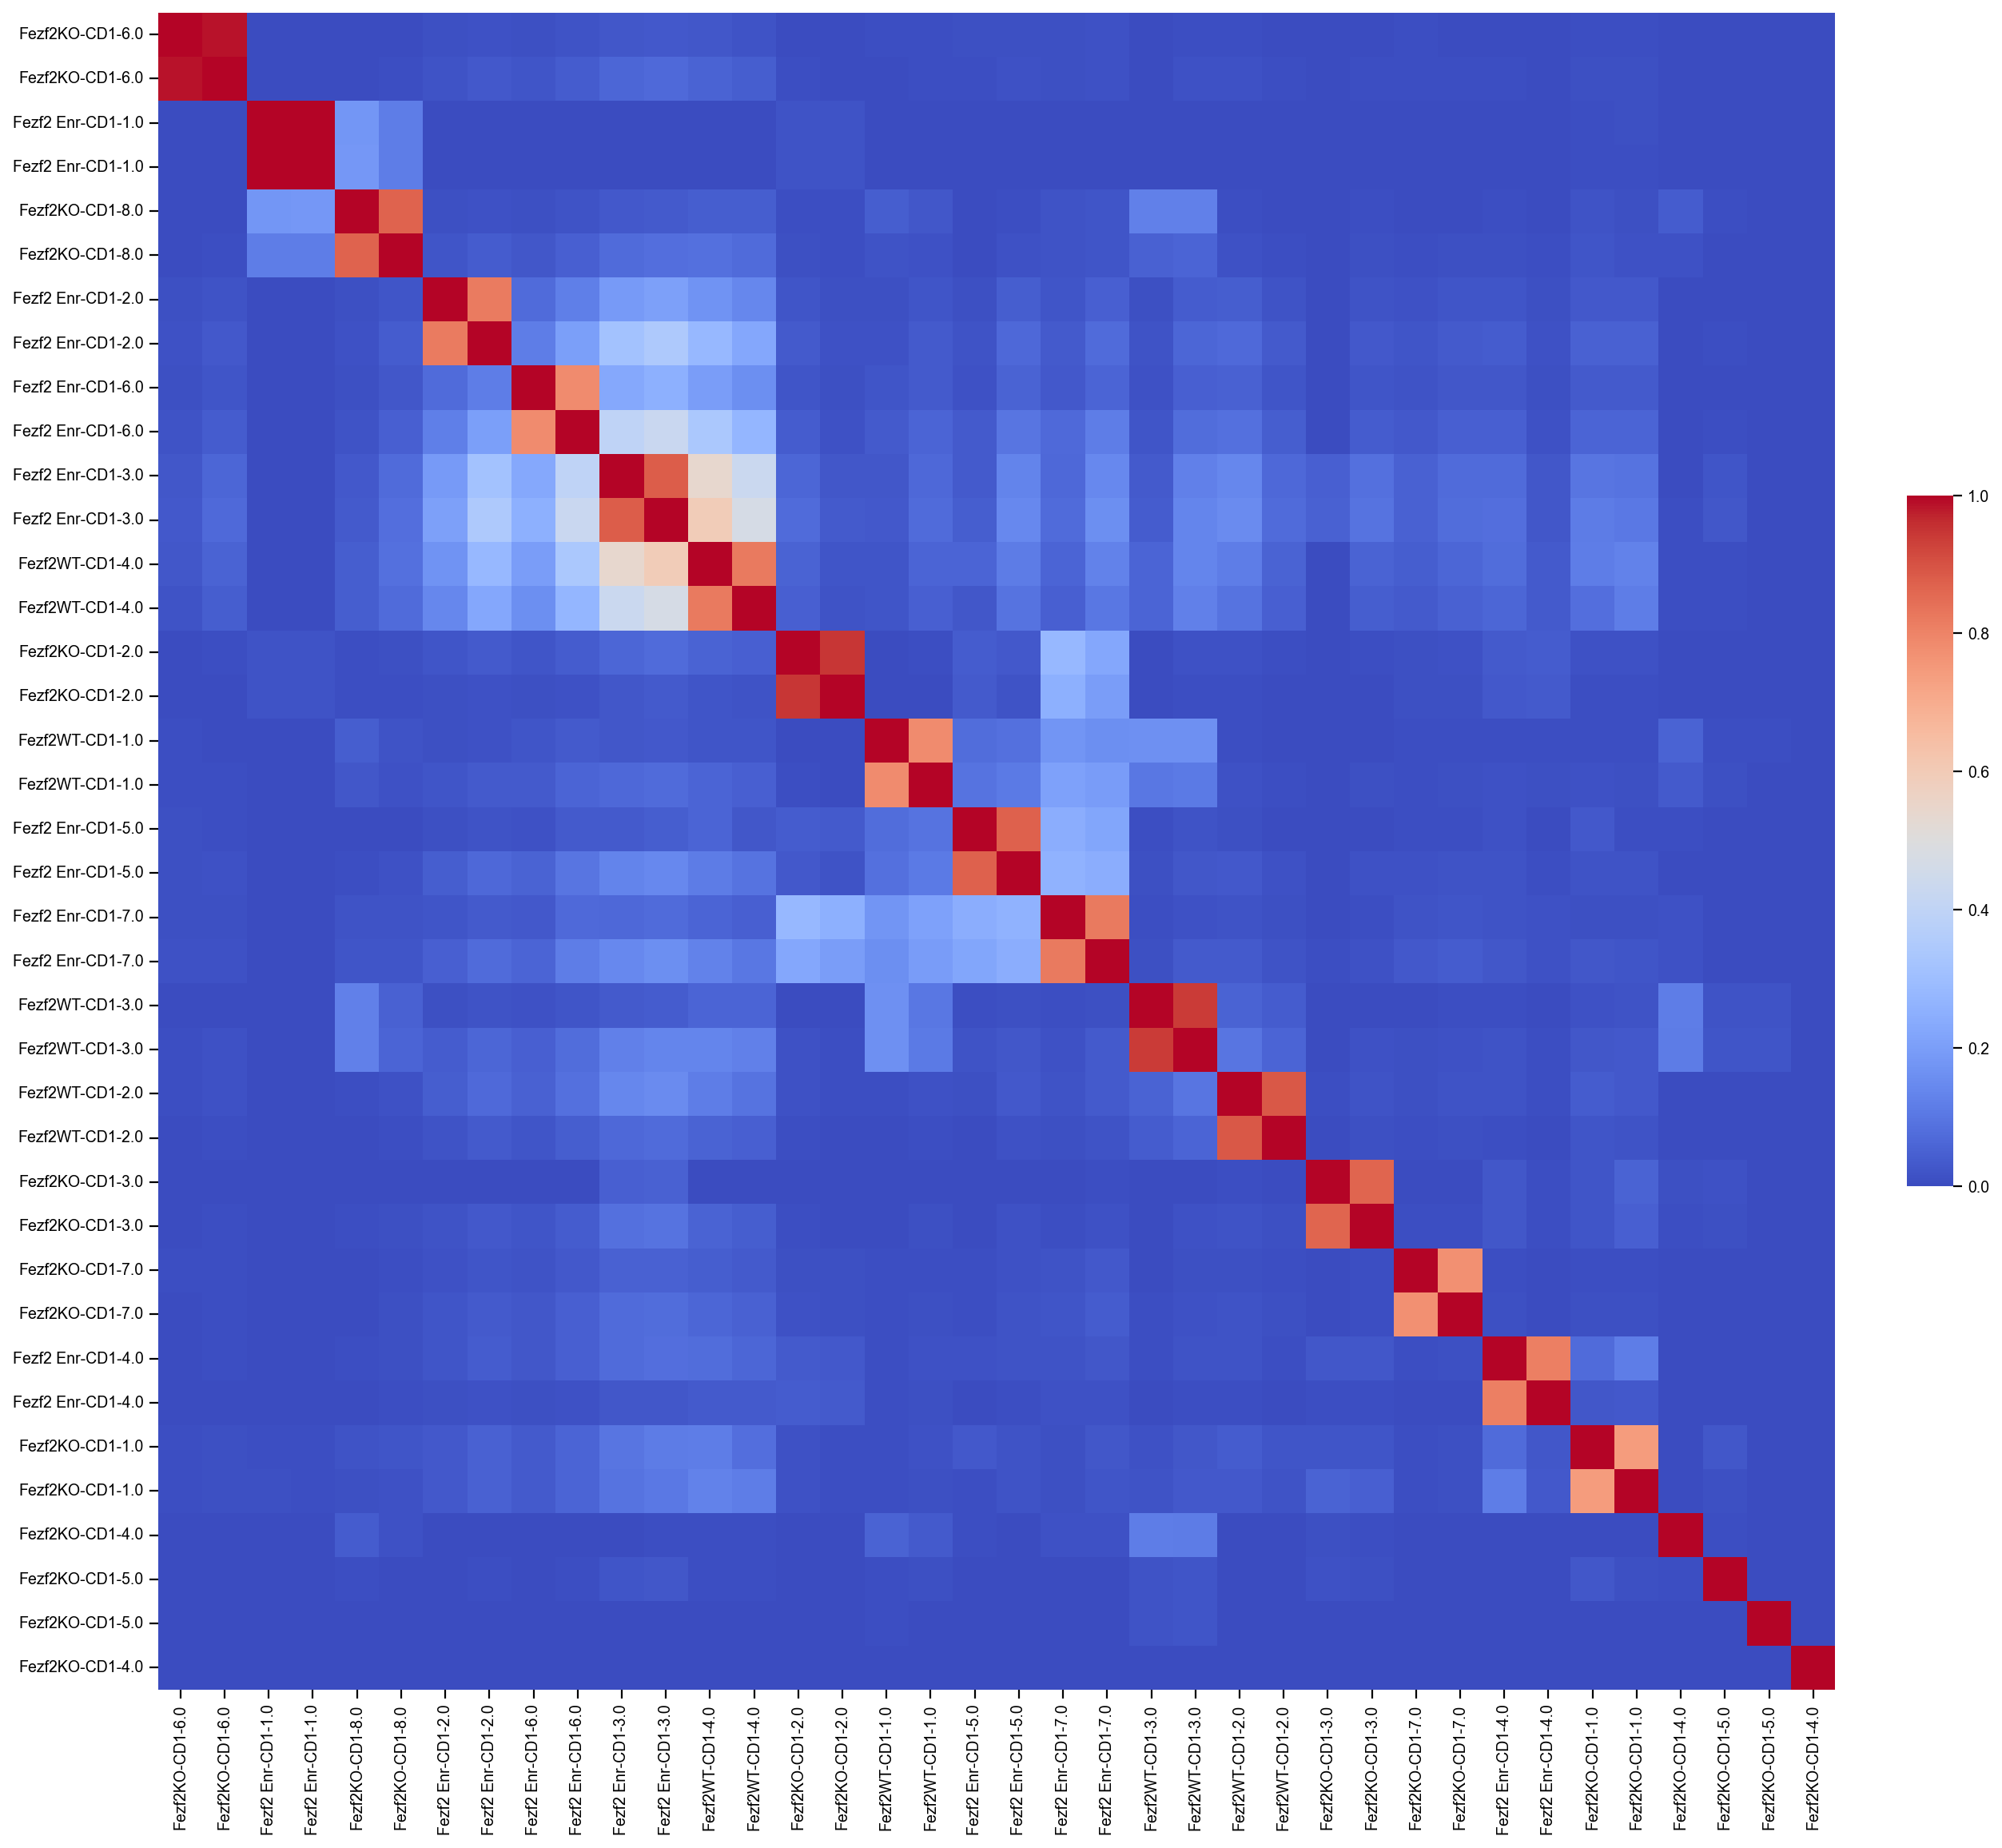

In [12]:
corr_plot(
    adata[adata.obs.Condition.isin(["Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"])],
    figsize=(18,18),
    layer="X",
    labels="SAMPLE_NAME",
    cbar_args=[0.95, 0.3, 0.02, 0.3],
    vmin=0,
    # save_path="../analysis/B6_phip_seq/technical_replicate_coorelation.pdf"
)

In [13]:
#Take average counts of technical replicates
averaged_adata = average_tech_reps(
    adata = adata,
    sample_key = "SAMPLE_NAME"
)

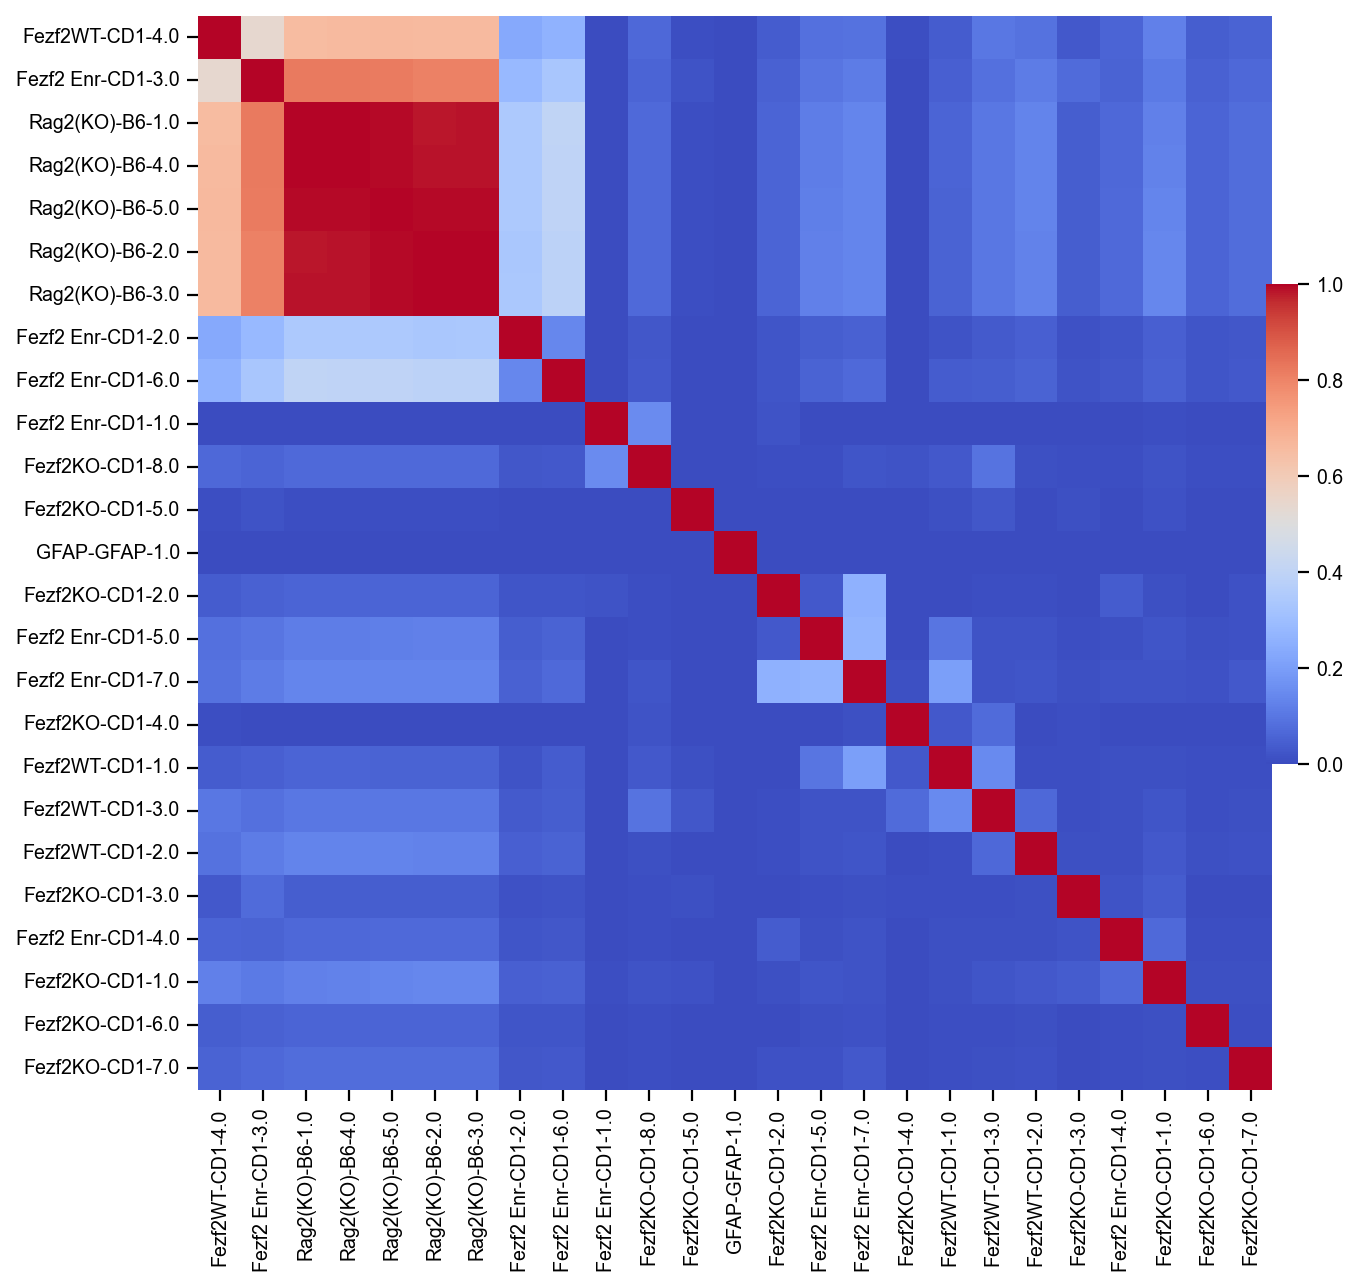

In [14]:
corr_plot(
    averaged_adata[averaged_adata.obs.Condition.isin(["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1", "GFAP-GFAP"])],
    layer="X",
    figsize=(10,10),
    labels="SAMPLE_NAME",
    vmin=0,
    cbar_args=[0.85, 0.35, 0.02, 0.3],
    # save_path="../analysis/B6_phip_seq/biological_replicate_coorelation.pdf"
)

## Add metadata columns to obs/var for analysis

In [15]:
#This file is publically available and can be accessed through https://www.protocols.io/workspaces/derisi-lab
new_annot = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/gene_annotations.csv", index_col=0)
averaged_adata.var["gene"] = new_annot.gene
averaged_adata.var["sequence"] = new_annot.sequence
averaged_adata.var["isoform"] = [f"isoform_{i.split('isoform')[1].split('_')[1]}" if "isoform" in i else "" for i in averaged_adata.var_names]
averaged_adata.var["gene_isoform"] = averaged_adata.var.gene + "_" + averaged_adata.var.isoform
averaged_adata.obs["neg_control"] = ["Background" if i in ["Rag2(KO)-B6"] else i for i in averaged_adata.obs.Condition]

# Normalize to background

In [16]:
# Pseudocount data for LFC calculation
averaged_adata.layers["rpk+1"] = averaged_adata.X + 1

In [17]:
calculate_FC(
    averaged_adata,
    control_key='neg_control',
    control_values=["Background"],
    layer='rpk+1',
    layer_added="FC_background"
)
averaged_adata.layers["LFC_background"] = np.log2(averaged_adata.layers["FC_background"])

# Global autoanitbody load

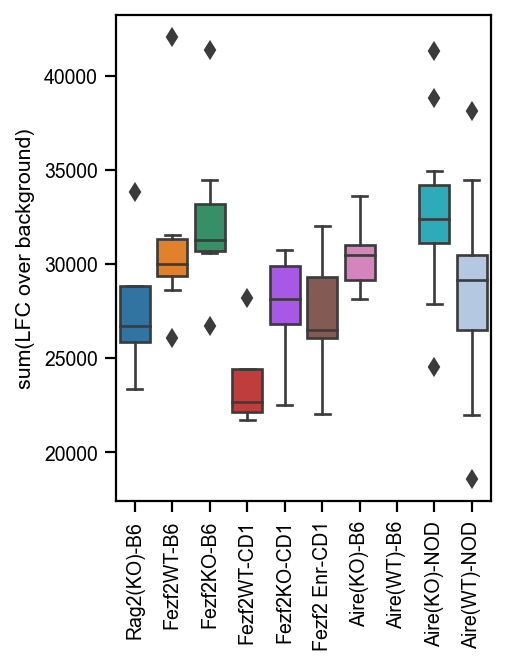

In [18]:
plot_FC_sum(
    averaged_adata,
    "LFC_background",
    "Condition",
    ["Rag2(KO)-B6", "Fezf2WT-B6", "Fezf2KO-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1", "Aire(KO)-B6", "Aire(WT)-B6", "Aire(KO)-NOD", "Aire(WT)-NOD"],
    order=["Rag2(KO)-B6", "Fezf2WT-B6", "Fezf2KO-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1", "Aire(KO)-B6", "Aire(WT)-B6", "Aire(KO)-NOD", "Aire(WT)-NOD"],
    # save_path="../analysis/B6_phip_seq/global_autoantibody_load.pdf"
)

# Z score

In [19]:
calculate_Z(
    averaged_adata,
    control_key='neg_control',
    control_values=["Background"],
    layer='LFC_background',
    layer_added="Z_score_background"
)
averaged_adata.layers["LZ_score_background"] = np.log2(averaged_adata.layers["Z_score_background"])

/tmp/ipykernel_1097719/824801542.py:8: RuntimeWarning: invalid value encountered in log2
  averaged_adata.layers["LZ_score_background"] = np.log2(averaged_adata.layers["Z_score_background"])


averaged_adata# Get peptide hits

In [20]:
averaged_adata.obs.neg_control.value_counts()

Aire(KO)-NOD     24
Aire(WT)-NOD     17
Fezf2KO-CD1       8
Fezf2WT-B6        8
Fezf2 Enr-CD1     7
Fezf2KO-B6        7
Aire(KO)-B6       5
Background        5
Fezf2WT-CD1       4
GFAP-GFAP         1
Name: neg_control, dtype: int64

# Compute hits stats

In [167]:
get_peptide_stats(
    averaged_adata,
    FC_layer = "LFC_background",
    FC_thresh = np.log2(3),
    Z_layer = "Z_score_background",
    Z_thresh = 3,
    obs_grouping_key="neg_control"
)

In [345]:
hits = averaged_adata.varm['hits_peptide'].copy()
gene_hits = averaged_adata.uns['hits_gene'].copy()

# Get hits

## Aire KO B6

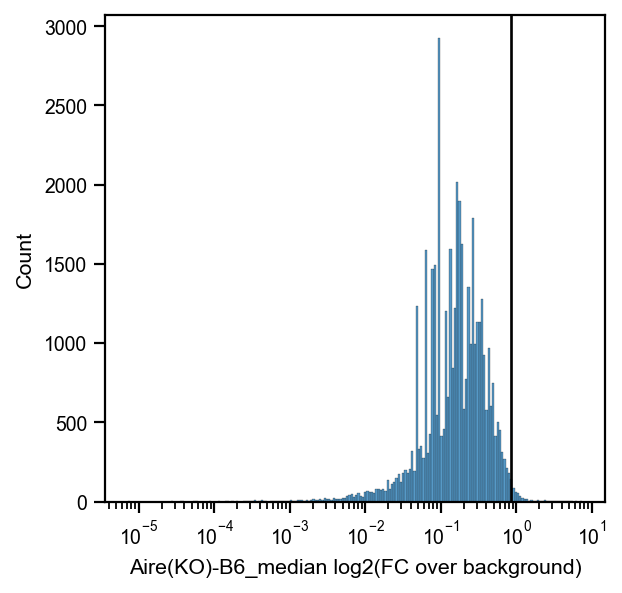

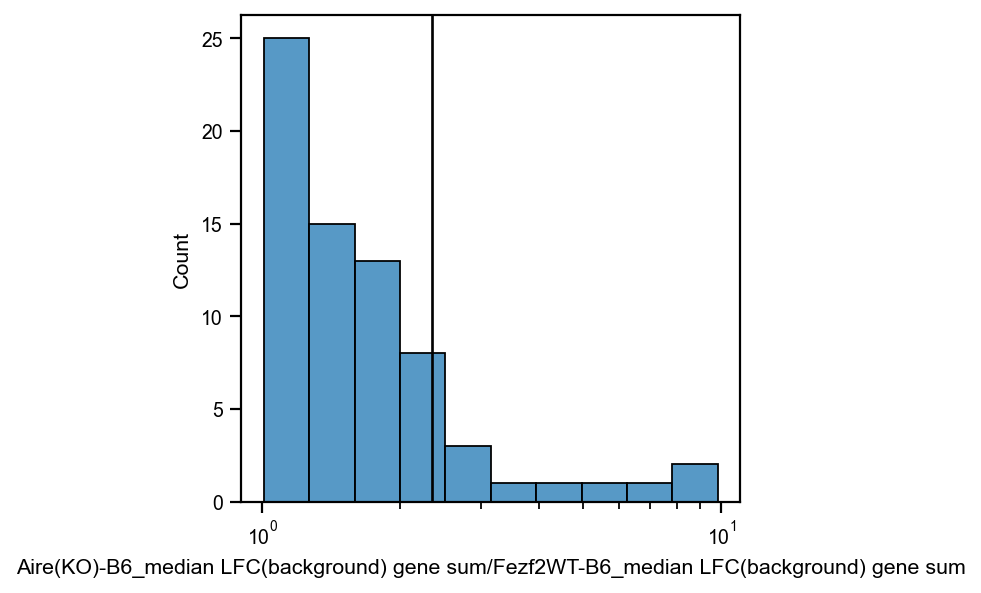

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(KO)-NOD_mean,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC
peptide,,,,,,,,,,,,,,,,,,,,,
NP_114395.1_interstitial_collagenase_A_preproprotein_[Mus_musculus]_seq7,3,1,0,0,0,0,0,0,0,0,...,0.178552,0.085066,0.000000,0.020401,0.192679,0.007763,0.033606,0.000000,0.095795,9.824537
NP_001239503.1_solute_carrier_family_35_member_C2_isoform_1_[Mus_musculus]_seq7,0,0,0,0,2,0,1,0,0,0,...,0.181201,0.080370,0.000000,0.549296,0.495536,0.744672,0.092469,0.000000,0.713707,5.811242
XP_006501359.1_PREDICTED:_short_transient_receptor_potential_channel_4_isoform_X1_[Mus_musculus]_seq22,0,0,0,0,1,0,0,0,0,0,...,0.184810,0.060570,0.000000,0.257003,0.000000,0.329732,0.011965,0.000000,0.024487,2.908360
XP_011242292.1_PREDICTED:_rho_GTPase-activating_protein_5_isoform_X1_[Mus_musculus]_seq28,0,1,0,0,1,0,1,0,1,0,...,0.375092,0.129306,0.007825,0.298964,0.105349,0.279232,0.052638,0.504458,0.572094,3.128481
NP_079789.1_exosome_complex_component_RRP40_[Mus_musculus]_seq1,1,0,0,0,0,1,0,0,0,0,...,0.191438,0.151456,0.198278,0.163119,0.772645,0.220279,0.221488,0.200580,0.000000,2.462457
XP_006528290.1_PREDICTED:_uncharacterized_protein_LOC628456_isoform_X1_[Mus_musculus]_seq1,1,1,1,0,0,0,1,0,0,0,...,0.352685,0.334697,0.000000,0.267016,0.503077,0.782055,0.144539,0.311876,0.313844,4.852362
XP_006533098.1_PREDICTED:_RUN_domain-containing_protein_1_isoform_X1_[Mus_musculus]_seq10,0,0,0,0,0,0,0,0,1,0,...,0.127966,0.059191,0.075617,0.016576,0.073614,0.003263,0.000000,0.716080,0.000000,8.701324
NP_081404.2_odontogenic_ameloblast-associated_protein_precursor_[Mus_musculus]_seq5,2,6,0,0,0,0,0,0,0,1,...,0.879140,0.090507,0.076296,0.000000,0.661715,0.200315,0.080843,0.000000,3.048102,2.415901
NP_001074280.1_Splunc6_precursor_[Mus_musculus]_seq2,3,4,0,0,0,0,0,0,0,0,...,1.227041,0.014342,0.072977,0.000000,0.012980,0.038414,0.032449,0.000000,0.000000,6.546057


In [480]:
genotype_stat = "Aire(KO)-B6_median"
control_genotype_stat = "Fezf2WT-B6_max"
hits_Aire_KO_B6 = hits[hits[genotype_stat] > 0].copy() # Get rid of peptides with LFC over background <= 0

background_thresh = np.quantile(hits_Aire_KO_B6[genotype_stat], 0.99)
sns.histplot(hits_Aire_KO_B6[genotype_stat], log_scale=True)
plt.axvline(x=background_thresh, c="black")
plt.xlabel(f"{genotype_stat} log2(FC over background)")
plt.show()

hits_Aire_KO_B6 = hits_Aire_KO_B6[hits_Aire_KO_B6[genotype_stat] >= background_thresh].copy()
hits_Aire_KO_B6 = hits_Aire_KO_B6[hits_Aire_KO_B6[control_genotype_stat] < background_thresh]
hits_Aire_KO_B6["gene_FC"] = list(gene_hits.loc[hits_Aire_KO_B6.gene, "Aire(KO)-B6_mean"]/gene_hits.loc[hits_Aire_KO_B6.gene, "Fezf2WT-B6_median"])

hits_Aire_KO_B6 = hits_Aire_KO_B6[hits_Aire_KO_B6["gene_FC"] > 1] # Get rid of peptides with gene-wise FC over wild type <= 1

unique_genes = hits_Aire_KO_B6.drop_duplicates(subset="gene")
gene_FC_thresh = np.quantile(unique_genes["gene_FC"], 0.85)
sns.histplot(unique_genes["gene_FC"], log_scale=True)
plt.axvline(x=gene_FC_thresh, c="black")
plt.xlabel("Aire(KO)-B6_median LFC(background) gene sum/Fezf2WT-B6_median LFC(background) gene sum")
plt.show()

hits_Aire_KO_B6 = hits_Aire_KO_B6[hits_Aire_KO_B6.gene_FC >= gene_FC_thresh]
hits_Aire_KO_B6

In [481]:
hits_Aire_KO_B6 = hits_Aire_KO_B6.sort_values(by="Aire(KO)-B6_median")
hits_Aire_KO_B6.gene

peptide
XP_006501359.1_PREDICTED:_short_transient_receptor_potential_channel_4_isoform_X1_[Mus_musculus]_seq22      Trpc4
XP_006533098.1_PREDICTED:_RUN_domain-containing_protein_1_isoform_X1_[Mus_musculus]_seq10                  Rundc1
NP_081404.2_odontogenic_ameloblast-associated_protein_precursor_[Mus_musculus]_seq5                          Odam
NP_079789.1_exosome_complex_component_RRP40_[Mus_musculus]_seq1                                            Exosc3
XP_011242292.1_PREDICTED:_rho_GTPase-activating_protein_5_isoform_X1_[Mus_musculus]_seq28                 Arhgap5
XP_006528290.1_PREDICTED:_uncharacterized_protein_LOC628456_isoform_X1_[Mus_musculus]_seq1                 Gm6880
NP_001239503.1_solute_carrier_family_35_member_C2_isoform_1_[Mus_musculus]_seq7                           Slc35c2
XP_011248171.1_PREDICTED:_zinc_finger_protein_431-like_[Mus_musculus]_seq2                                Gm39469
NP_659066.1_calcium/calmodulin-dependent_protein_kinase_type_1G_[Mus_musculus]_s

In [482]:
hits_Aire_KO_B6.gene_FC

peptide
XP_006501359.1_PREDICTED:_short_transient_receptor_potential_channel_4_isoform_X1_[Mus_musculus]_seq22    2.908360
XP_006533098.1_PREDICTED:_RUN_domain-containing_protein_1_isoform_X1_[Mus_musculus]_seq10                 8.701324
NP_081404.2_odontogenic_ameloblast-associated_protein_precursor_[Mus_musculus]_seq5                       2.415901
NP_079789.1_exosome_complex_component_RRP40_[Mus_musculus]_seq1                                           2.462457
XP_011242292.1_PREDICTED:_rho_GTPase-activating_protein_5_isoform_X1_[Mus_musculus]_seq28                 3.128481
XP_006528290.1_PREDICTED:_uncharacterized_protein_LOC628456_isoform_X1_[Mus_musculus]_seq1                4.852362
NP_001239503.1_solute_carrier_family_35_member_C2_isoform_1_[Mus_musculus]_seq7                           5.811242
XP_011248171.1_PREDICTED:_zinc_finger_protein_431-like_[Mus_musculus]_seq2                                2.534512
NP_659066.1_calcium/calmodulin-dependent_protein_kinase_type_1G_[Mus_mus

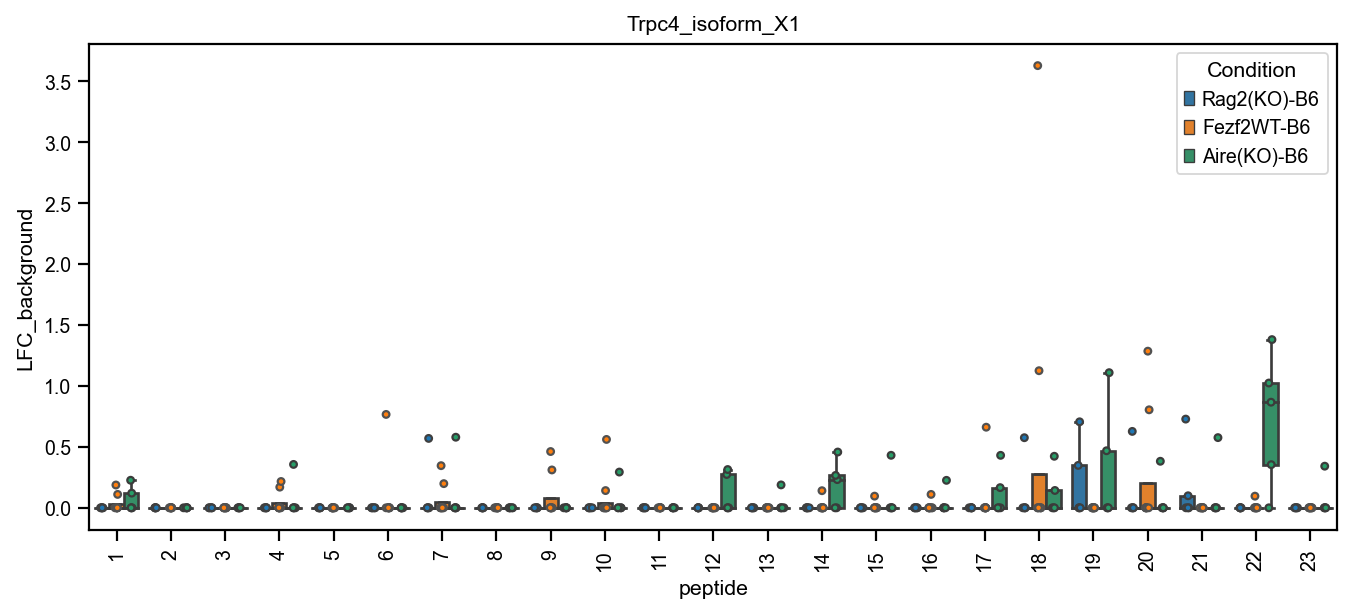

In [483]:
gene_level_box_plot(
    averaged_adata[averaged_adata.obs.Condition.isin(["Rag2(KO)-B6", "Fezf2WT-B6", "Aire(KO)-B6"])],
    "Condition",
    layer="LFC_background",
    gene="Trpc4",
    isoform_subset = "isoform_X1",
    figsize=(10,4),
    hue_order=["Rag2(KO)-B6", "Fezf2WT-B6", "Aire(KO)-B6"]
)

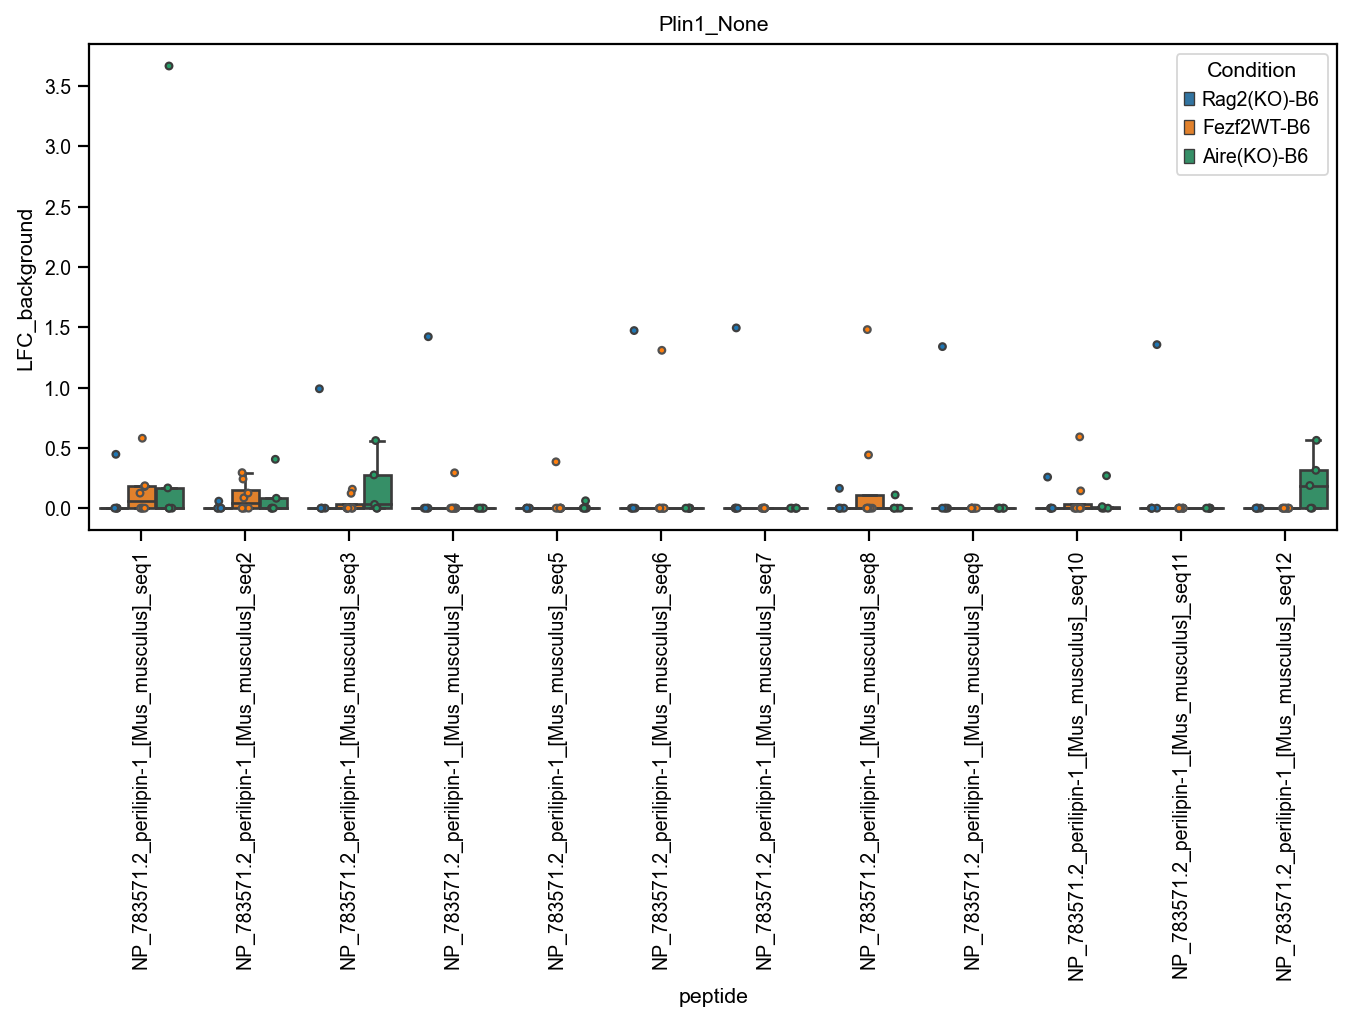

In [464]:
gene_level_box_plot(
    averaged_adata[averaged_adata.obs.Condition.isin(["Rag2(KO)-B6", "Fezf2WT-B6", "Aire(KO)-B6"])],
    "Condition",
    layer="LFC_background",
    gene="Plin1",
    figsize=(10,4),
    hue_order=["Rag2(KO)-B6", "Fezf2WT-B6", "Aire(KO)-B6"]
)

## Aire KO NOD

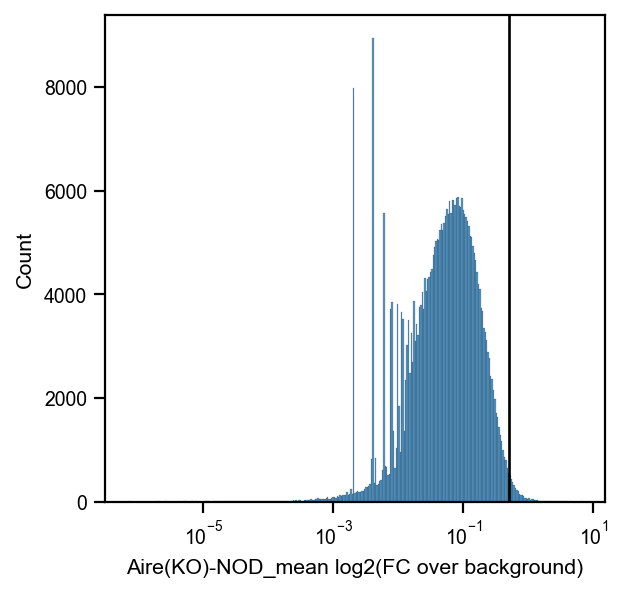

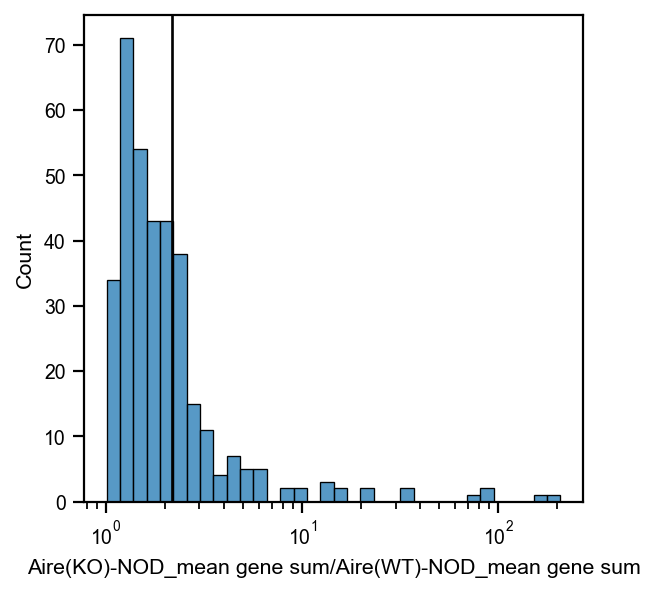

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC,isoform
peptide,,,,,,,,,,,,,,,,,,,,,
NP_783571.2_perilipin-1_[Mus_musculus]_seq7,0,7,0,0,0,0,0,0,0,0,...,0.000000,0.299024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.234995,Plin1_
NP_783571.2_perilipin-1_[Mus_musculus]_seq11,0,2,0,0,0,0,0,0,2,0,...,0.033678,0.271303,0.173159,0.084029,0.000000,0.000000,1.534337,0.000000,20.234995,Plin1_
NP_783571.2_perilipin-1_[Mus_musculus]_seq12,0,3,0,0,1,0,0,0,0,0,...,0.054818,0.000000,0.250081,0.026774,0.000000,0.000000,0.000000,0.000000,20.234995,Plin1_
XP_006525247.1_PREDICTED:_G_patch_domain_and_ankyrin_repeat-containing_protein_1_isoform_X1_[Mus_musculus]_seq7,0,4,0,0,0,0,0,1,0,0,...,0.000000,0.226194,0.057669,0.086284,0.000000,1.022298,0.000000,0.000000,3.177326,Gpank1_isoform_X1
NP_080497.1_liprin-beta-1_isoform_2_[Mus_musculus]_seq14,0,4,0,0,0,0,0,0,0,0,...,0.083129,0.000000,0.103421,0.153731,0.032709,0.416939,0.000000,0.310904,2.651060,Ppfibp1_isoform_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_059086.3_semenogelin_I_precursor_[Mus_musculus]_seq9,1,2,0,0,0,0,0,0,0,0,...,0.047572,0.000000,0.000000,0.151701,0.176586,0.053172,0.000000,0.206720,73.239952,Svs2_
NP_001159905.1_uncharacterized_protein_CXorf67_homolog_isoform_1_[Mus_musculus]_seq2,1,2,0,0,0,0,0,0,0,0,...,0.000698,0.257970,0.000000,0.185569,0.000000,0.000000,0.000000,0.000000,5.302911,AU022751_isoform_1
NP_001159905.1_uncharacterized_protein_CXorf67_homolog_isoform_1_[Mus_musculus]_seq3,0,2,0,0,0,0,0,0,0,0,...,0.000000,0.242522,0.000000,0.008555,0.000000,0.100343,0.000000,0.000000,5.302911,AU022751_isoform_1


In [903]:
genotype_stat = "Aire(KO)-NOD_mean"
control_genotype_stat = "Aire(WT)-NOD_max"
hits_Aire_KO_NOD = hits[hits[genotype_stat] > 0].copy() # Get rid of peptides with LFC over background <= 0

background_thresh = np.quantile(hits_Aire_KO_NOD[genotype_stat], 0.99)
sns.histplot(hits_Aire_KO_NOD[genotype_stat], log_scale=True)
plt.axvline(x=background_thresh, c="black")
plt.xlabel(f"{genotype_stat} log2(FC over background)")
plt.show()

hits_Aire_KO_NOD = hits_Aire_KO_NOD[hits_Aire_KO_NOD[genotype_stat] >= background_thresh].copy()
hits_Aire_KO_NOD = hits_Aire_KO_NOD[hits_Aire_KO_NOD[control_genotype_stat] < background_thresh]
hits_Aire_KO_NOD["gene_FC"] = list(gene_hits.loc[hits_Aire_KO_NOD.gene, "Aire(KO)-NOD_mean"]/gene_hits.loc[hits_Aire_KO_NOD.gene, "Aire(WT)-NOD_mean"])

hits_Aire_KO_NOD = hits_Aire_KO_NOD[hits_Aire_KO_NOD["gene_FC"] > 1] # Get rid of peptides with gene-wise FC over wild type <= 1

unique_genes = hits_Aire_KO_NOD.drop_duplicates(subset="gene")
gene_FC_thresh = np.quantile(unique_genes["gene_FC"], 0.7)
sns.histplot(unique_genes["gene_FC"], log_scale=True)
plt.axvline(x=gene_FC_thresh, c="black")
plt.xlabel("Aire(KO)-NOD_mean gene sum/Aire(WT)-NOD_mean gene sum")
plt.show()

isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in hits_Aire_KO_NOD.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
hits_Aire_KO_NOD["isoform"] = hits_Aire_KO_NOD.gene + "_" + isoform

hits_Aire_KO_NOD = hits_Aire_KO_NOD[hits_Aire_KO_NOD.gene_FC >= gene_FC_thresh]
hits_Aire_KO_NOD

In [904]:
hits_Aire_KO_NOD = hits_Aire_KO_NOD.sort_values(by="Aire(KO)-NOD_mean")
hits_Aire_KO_NOD.gene

peptide
XP_011246286.1_PREDICTED:_importin-9_isoform_X1_[Mus_musculus]_seq23                              Ipo9
NP_032158.2_glutamine_repeat_protein_1_[Mus_musculus]_seq3                                       Glrp1
NP_666326.1_tyrosine_aminotransferase_[Mus_musculus]_seq7                                          Tat
NP_033079.1_beta-1_3-N-acetylglucosaminyltransferase_radical_fringe_[Mus_musculus]_seq5           Rfng
NP_680088.1_pulmonary_surfactant-associated_protein_B_isoform_1_precursor_[Mus_musculus]_seq9    Sftpb
                                                                                                 ...  
NP_059086.3_semenogelin_I_precursor_[Mus_musculus]_seq4                                           Svs2
NP_067338.2_seminal_vesicle_secretion_3_alpha_isoform_1_precursor_[Mus_musculus]_seq4            Svs3a
XP_006529294.1_PREDICTED:_melanophilin_isoform_X1_[Mus_musculus]_seq5                             Mlph
NP_059086.3_semenogelin_I_precursor_[Mus_musculus]_seq8          

In [905]:
hits_Aire_KO_NOD.gene_FC

peptide
XP_011246286.1_PREDICTED:_importin-9_isoform_X1_[Mus_musculus]_seq23                               2.269430
NP_032158.2_glutamine_repeat_protein_1_[Mus_musculus]_seq3                                         5.712604
NP_666326.1_tyrosine_aminotransferase_[Mus_musculus]_seq7                                          2.619928
NP_033079.1_beta-1_3-N-acetylglucosaminyltransferase_radical_fringe_[Mus_musculus]_seq5            3.058634
NP_680088.1_pulmonary_surfactant-associated_protein_B_isoform_1_precursor_[Mus_musculus]_seq9     15.809039
                                                                                                    ...    
NP_059086.3_semenogelin_I_precursor_[Mus_musculus]_seq4                                           73.239952
NP_067338.2_seminal_vesicle_secretion_3_alpha_isoform_1_precursor_[Mus_musculus]_seq4            169.604218
XP_006529294.1_PREDICTED:_melanophilin_isoform_X1_[Mus_musculus]_seq5                              5.202383
NP_059086.3_semenoge

In [906]:
hits_Aire_KO_NOD[hits_Aire_KO_NOD.gene == "Glrp1"]

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC,isoform
peptide,,,,,,,,,,,,,,,,,,,,,
NP_032158.2_glutamine_repeat_protein_1_[Mus_musculus]_seq3,0,4,0,0,0,0,0,0,0,0,...,0.005302,0.003921,0.006174,0.006197,0.0,0.024154,0.0,0.180193,5.712604,Glrp1_


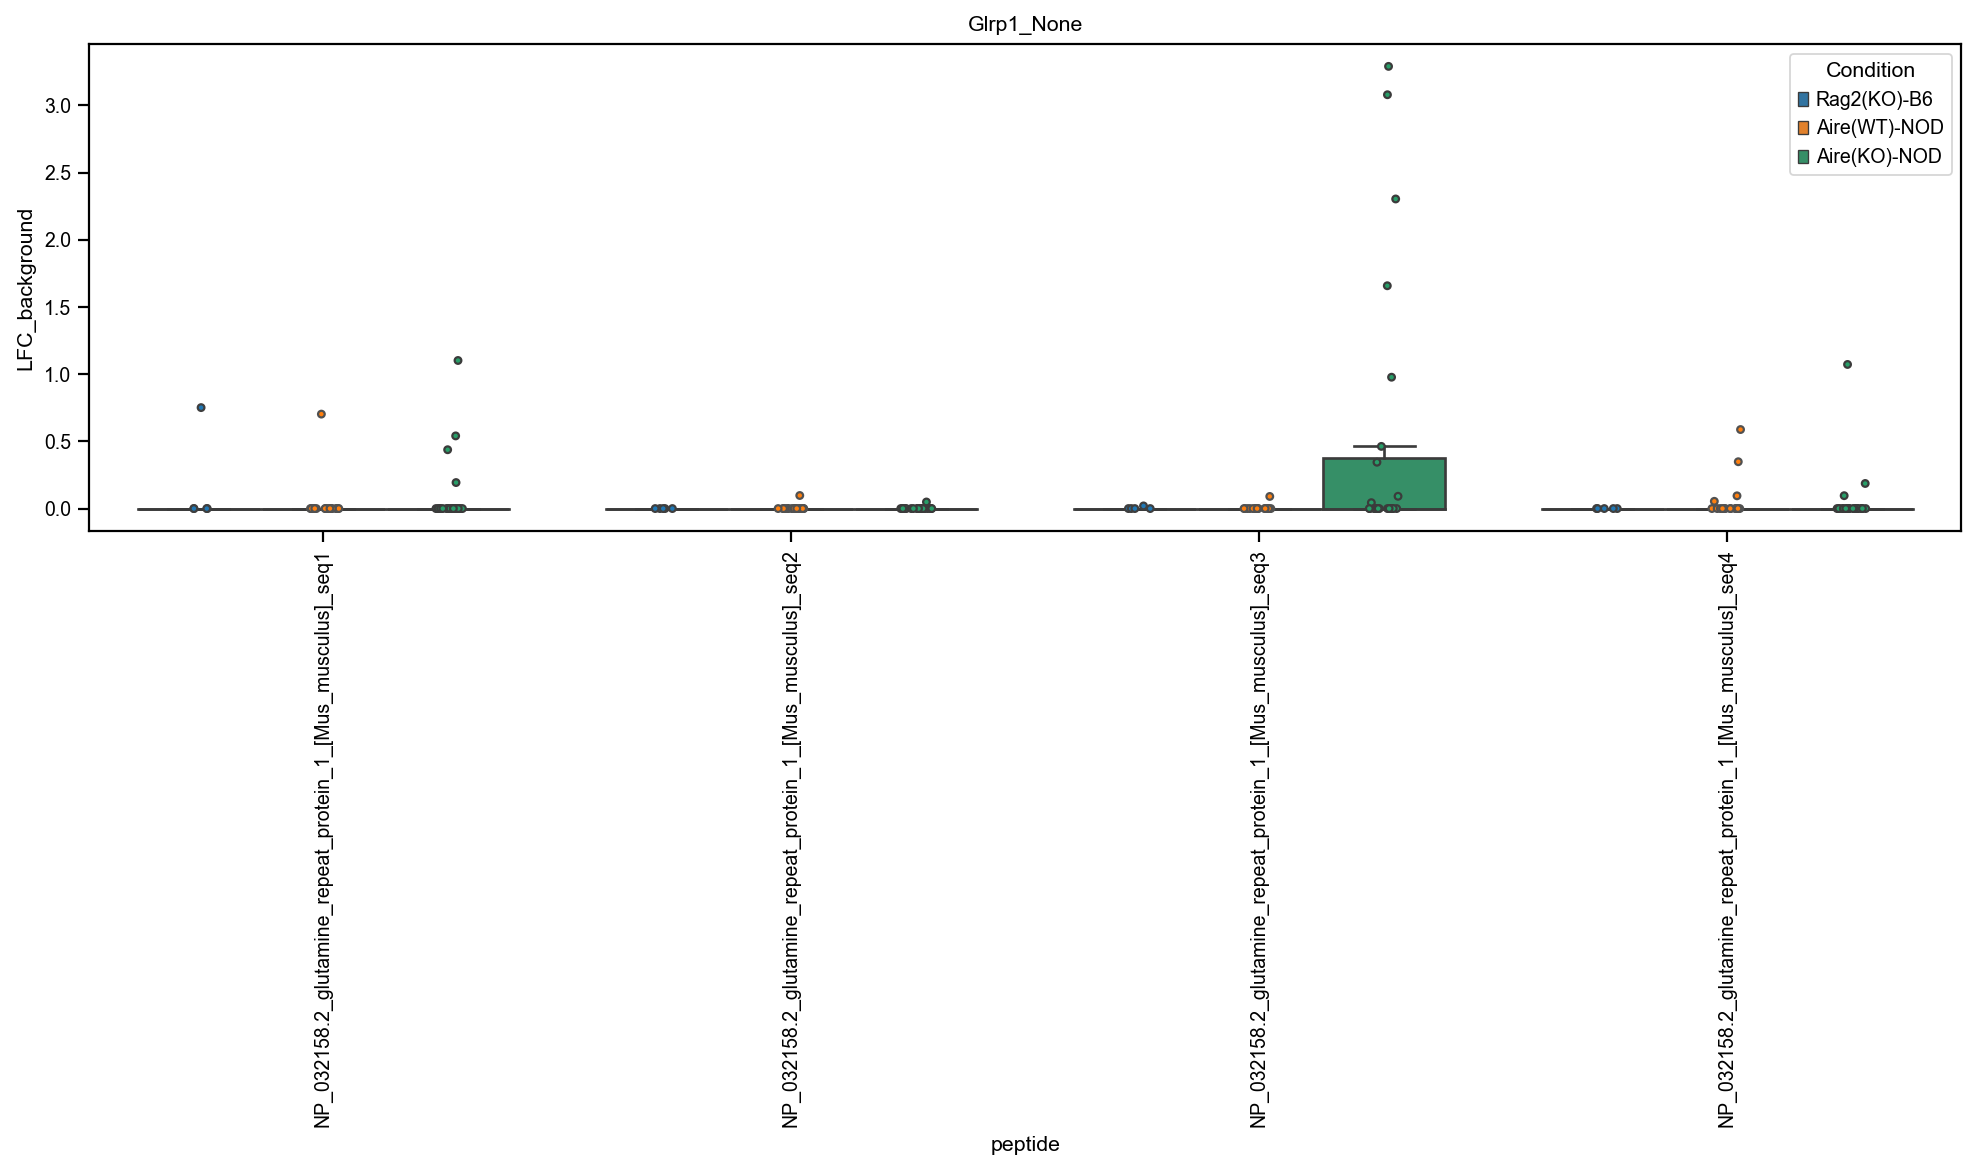

In [907]:
gene_level_box_plot(
    averaged_adata,
    "Condition",
    layer="LFC_background",
    gene="Glrp1",
    # isoform_subset = "isoform_2",
    figsize=(15,4),
    hue_order=["Rag2(KO)-B6", "Aire(WT)-NOD", "Aire(KO)-NOD"],
    # threshold=np.log2(2)
)

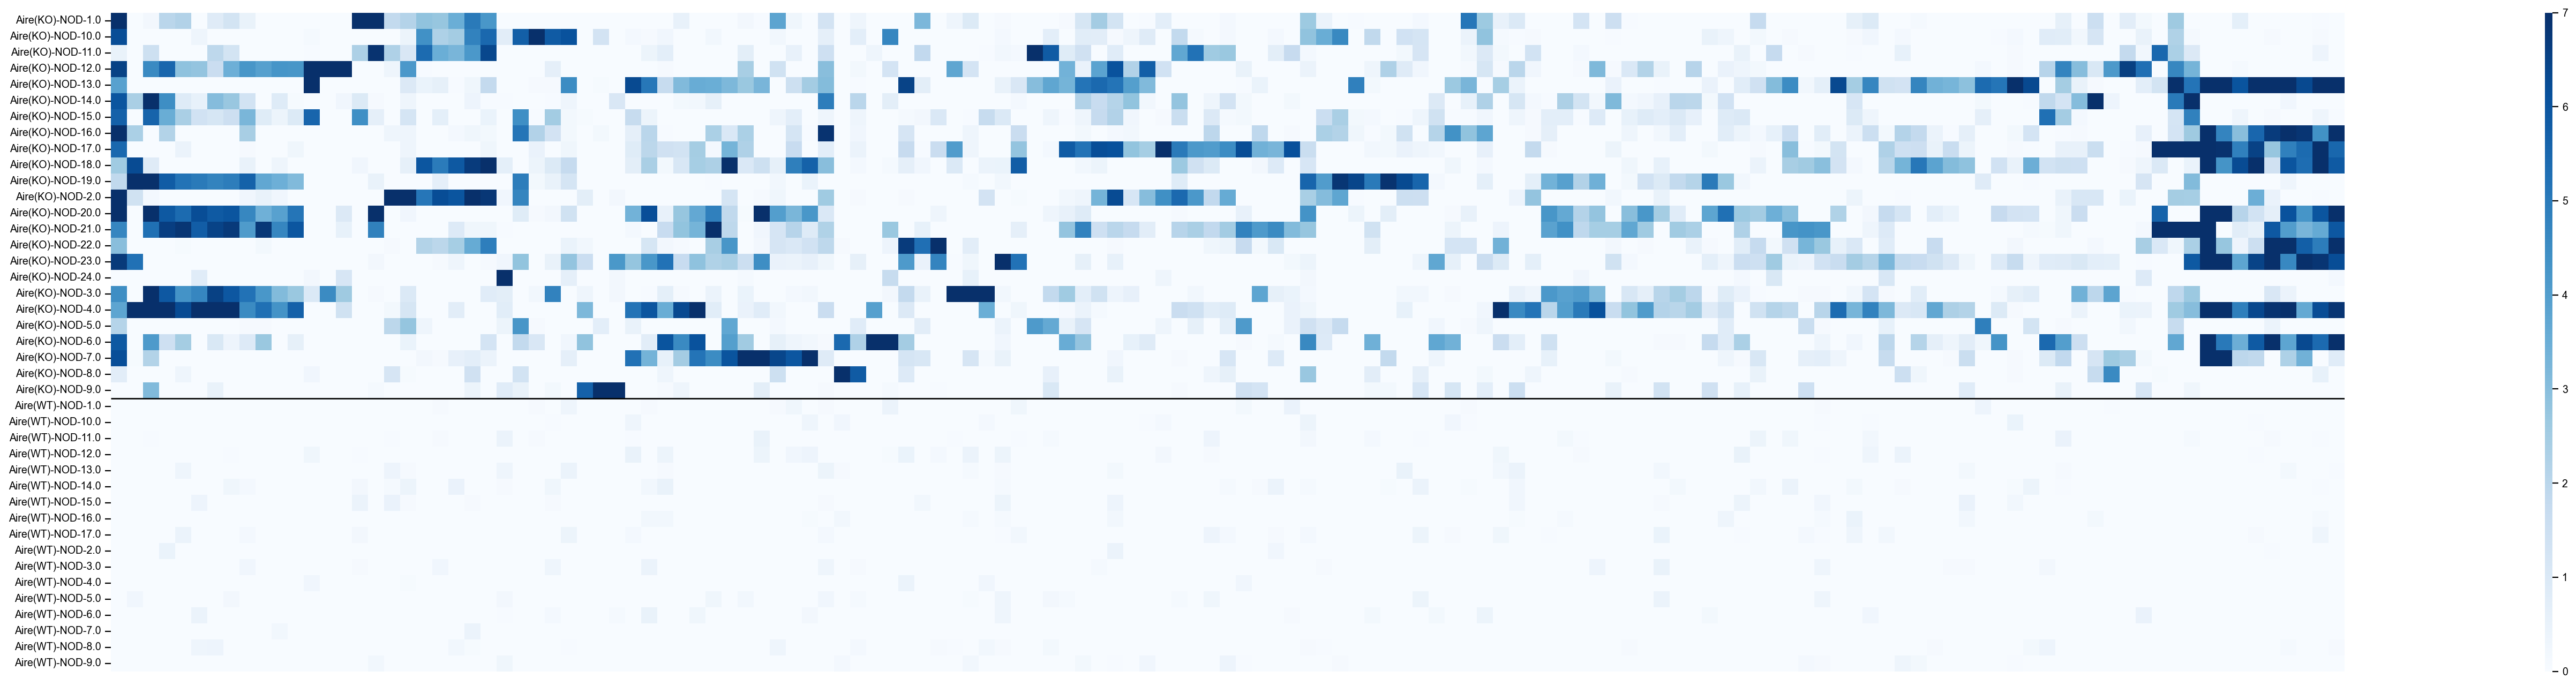

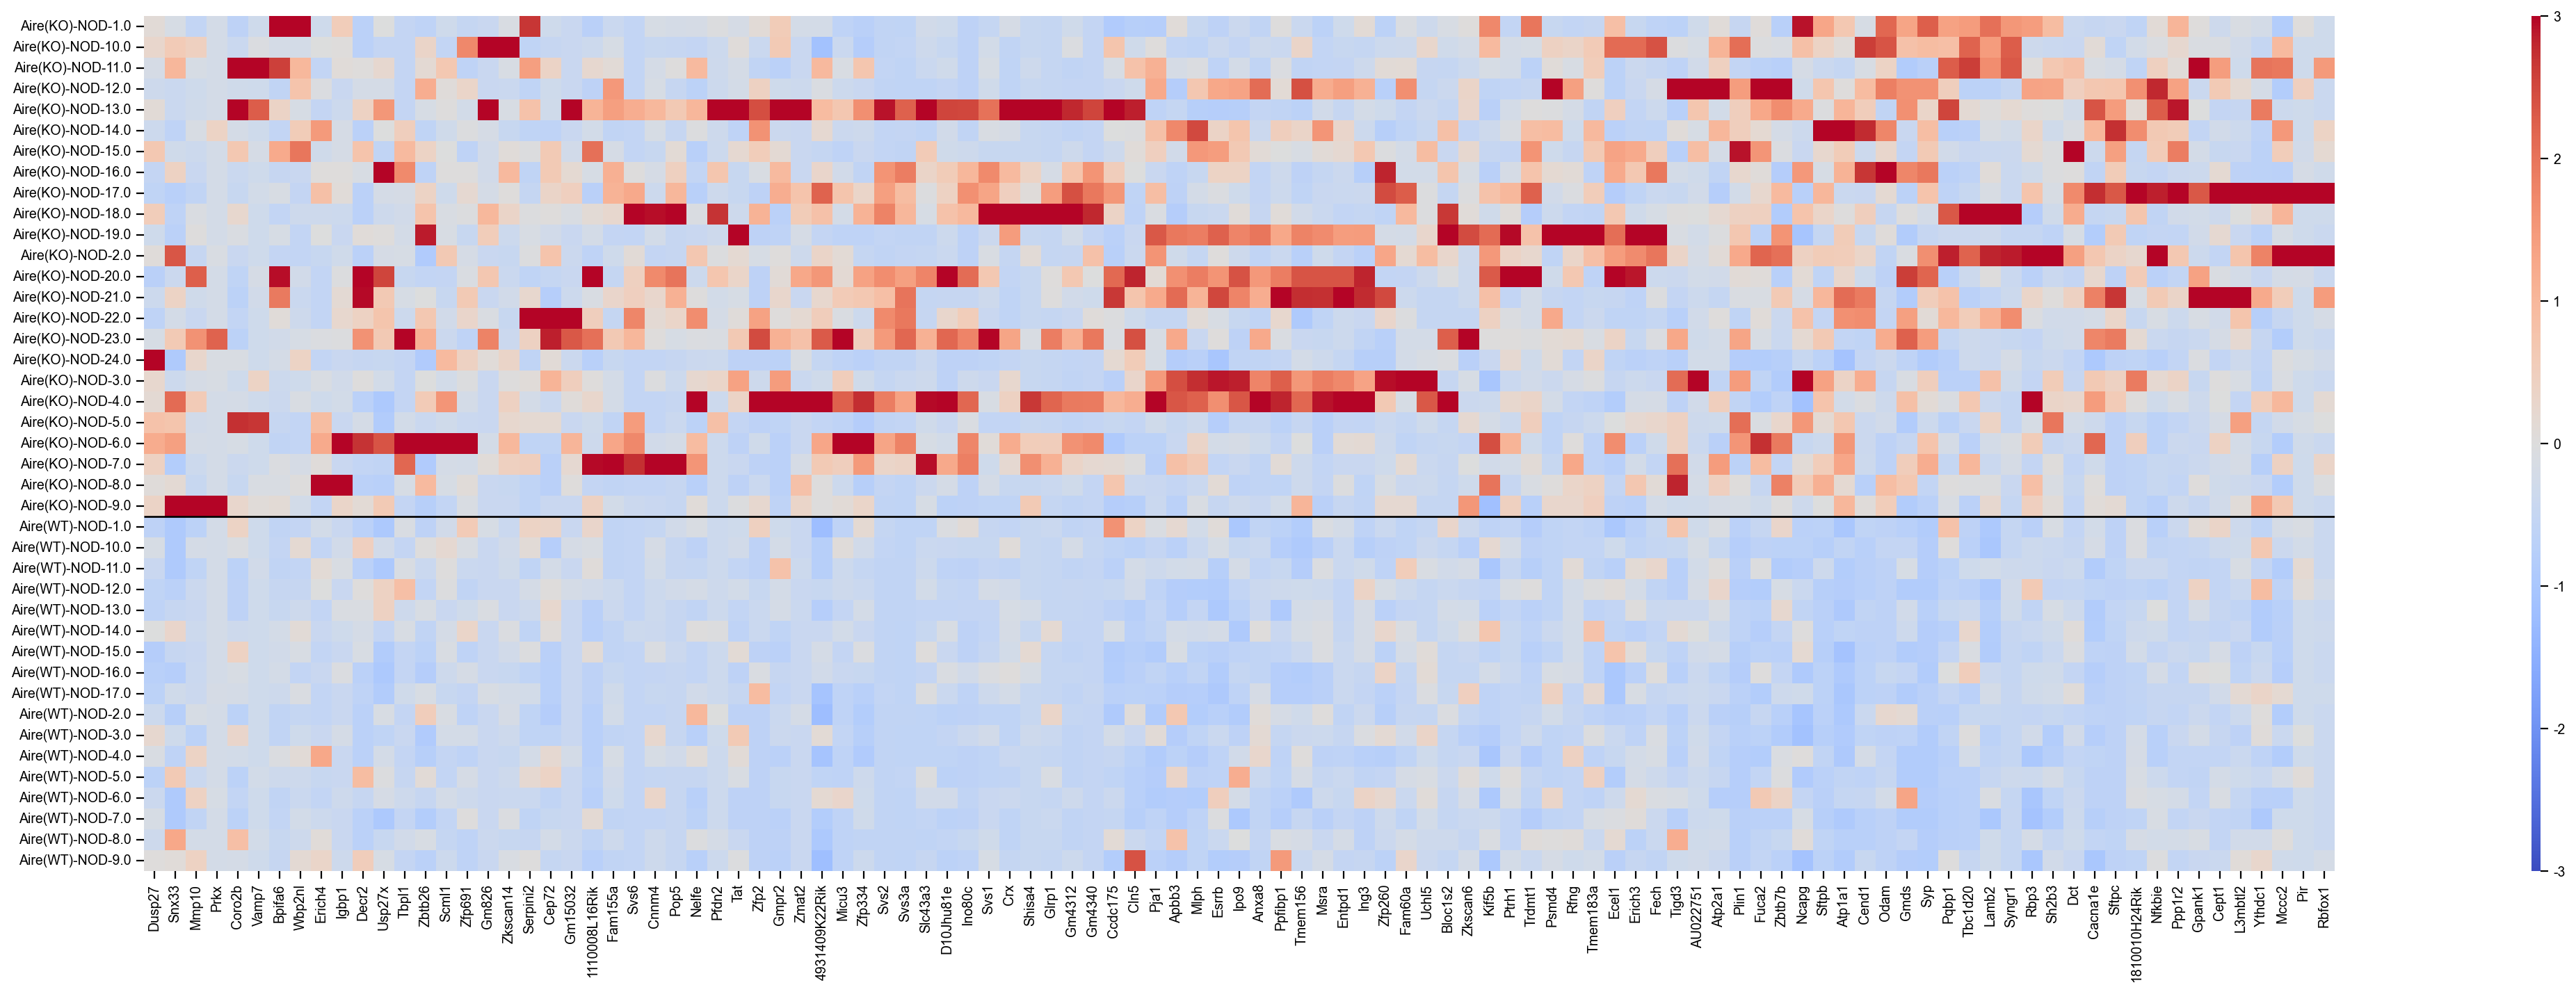

In [908]:
lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.contains("Aire") & lfc_data_peptide.index.str.contains("NOD"),
    hits_Aire_KO_NOD.index
]
LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=7,
    cell_width=15,
    cell_height=15,
    xticklabels=False,
    grouping=[24]
)

lfc_data_peptide = rna.tl.get_expression_matrix(
    averaged_adata[:, averaged_adata.var.gene.isin(hits_Aire_KO_NOD.gene)],
    gene_data="LFC_background"
).copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.contains("Aire") & lfc_data_peptide.index.str.contains("NOD"),
    :
].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in lfc_data_peptide.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
lfc_data_peptide["isoform"] = lfc_data_peptide.gene + "_" + isoform

lfc_data_peptide = lfc_data_peptide[lfc_data_peptide.isoform.isin(hits_Aire_KO_NOD.isoform)]
del lfc_data_peptide["isoform"]

lfc_data_peptide = lfc_data_peptide.groupby("gene").sum().T

LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="coolwarm",
    vmax=3,
    vmin=-3,
    z_score=1,
    cell_width=15,
    cell_height=15,
    xticklabels=True,
    grouping=[24]
)

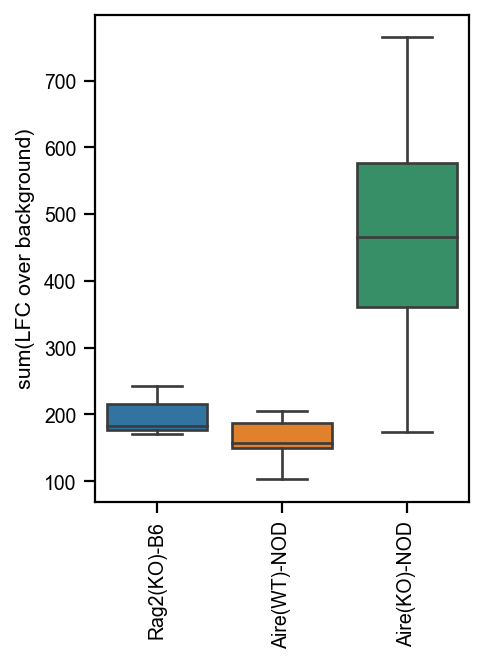

In [902]:
plot_FC_sum(
    averaged_adata[:,averaged_adata.var.gene.isin(hits_Aire_KO_NOD.gene)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Aire(WT)-NOD", "Aire(KO)-NOD"],
    order=["Rag2(KO)-B6", "Aire(WT)-NOD", "Aire(KO)-NOD"],
    save_path=None
)

## Fezf2 KO B6

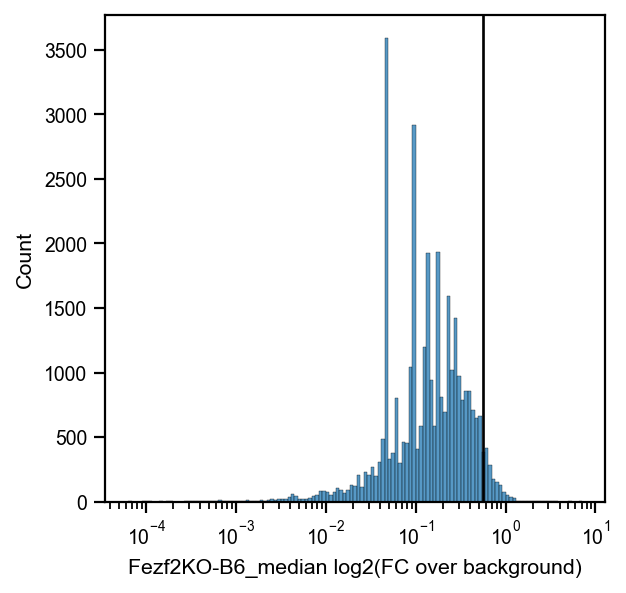

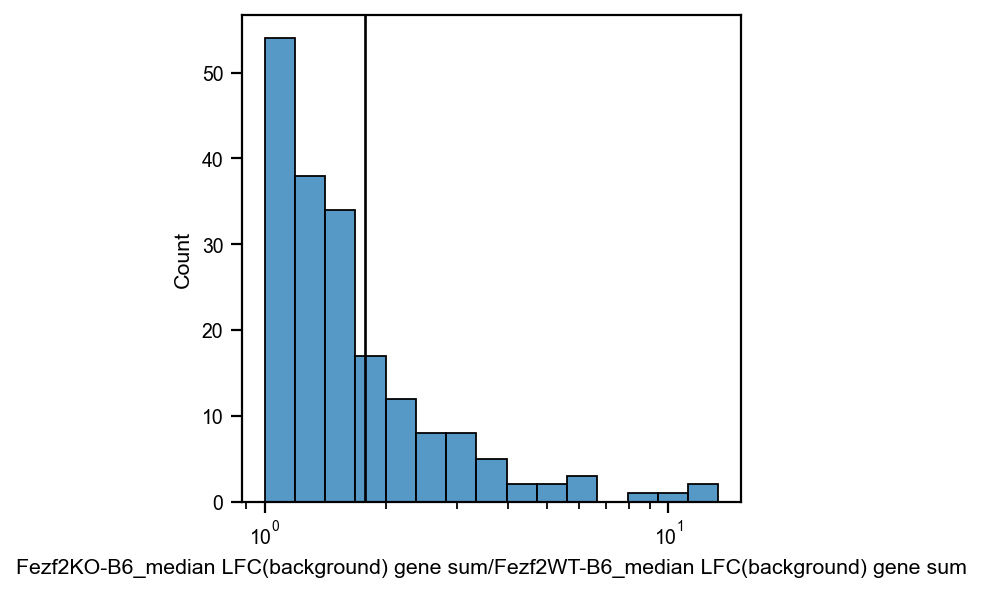

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(KO)-NOD_mean,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC
peptide,,,,,,,,,,,,,,,,,,,,,
NP_079631.2_transcription_elongation_factor_A_(SII)-like_6_[Mus_musculus]_seq2,0,1,0,0,0,0,1,0,0,0,...,0.279555,0.244006,0.025061,0.081919,0.585196,0.444633,0.065496,0.000000,1.573639,4.113142
XP_017171748.1_PREDICTED:_uncharacterized_protein_LOC108168152_isoform_X3_[Mus_musculus]_seq1,0,0,1,0,0,1,0,0,0,0,...,0.326413,0.376071,0.000000,0.118409,0.794917,0.195478,0.146417,0.311876,0.141050,1.850232
XP_006538025.1_PREDICTED:_thiosulfate_sulfurtransferase/rhodanese-like_domain-containing_protein_2_isoform_X1_[Mus_musculus]_seq7,0,0,0,0,0,0,0,0,0,0,...,0.203143,0.358299,0.003921,0.031916,0.615507,0.136462,0.169898,0.120491,0.722087,2.798755
NP_001280615.1_vesicle_transport_through_interaction_with_t-SNAREs_homolog_1A_isoform_3_[Mus_musculus]_seq2,0,4,0,0,0,0,0,0,0,0,...,0.994213,0.157524,0.297032,0.137578,0.525230,0.123703,0.010180,0.187795,1.719863,3.477491
XP_017171905.1_PREDICTED:_voltage-dependent_L-type_calcium_channel_subunit_beta-3_isoform_X6_[Mus_musculus]_seq4,0,0,0,0,0,2,1,0,1,0,...,0.050111,0.086460,0.153909,0.335904,1.854463,0.945713,0.076364,0.540669,0.120289,2.452374
XP_006530380.1_PREDICTED:_protein_strawberry_notch_homolog_1_isoform_X1_[Mus_musculus]_seq20,0,0,0,0,1,0,0,0,0,0,...,0.065746,0.094741,0.000000,0.398425,0.585925,0.101171,0.029472,0.188515,0.608772,2.518003
NP_789806.1_protein_FAM76B_[Mus_musculus]_seq7,0,0,0,0,1,0,0,0,0,0,...,0.109599,0.080853,0.096613,0.799683,0.674772,0.157700,0.058809,0.000000,0.076828,1.945643
XP_006521117.1_PREDICTED:_zinc_finger_protein_385A_isoform_X2_[Mus_musculus]_seq5,0,0,0,0,0,0,0,0,1,0,...,0.106213,0.029937,0.181220,0.000000,0.450265,0.223987,0.000000,0.618071,0.000000,2.134568
XP_017172308.1_PREDICTED:_spermatid_perinuclear_RNA-binding_protein_isoform_X1_[Mus_musculus]_seq1,0,0,0,0,0,1,0,0,1,0,...,0.065727,0.052364,0.168206,0.111317,0.785186,0.000000,0.078565,0.474515,0.000000,2.344967


In [876]:
genotype_stat = "Fezf2KO-B6_median"
control_genotype_stat = "Fezf2WT-B6_max"
hits_Fezf2_KO_B6 = hits[hits[genotype_stat] > 0].copy() # Get rid of peptides with LFC over background <= 0

background_thresh = np.quantile(hits_Fezf2_KO_B6[genotype_stat], 0.95)
sns.histplot(hits_Fezf2_KO_B6[genotype_stat], log_scale=True)
plt.axvline(x=background_thresh, c="black")
plt.xlabel(f"{genotype_stat} log2(FC over background)")
plt.show()

hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6[hits_Fezf2_KO_B6[genotype_stat] >= background_thresh].copy()
hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6[hits_Fezf2_KO_B6[control_genotype_stat] < background_thresh]
hits_Fezf2_KO_B6["gene_FC"] = list(gene_hits.loc[hits_Fezf2_KO_B6.gene, "Fezf2KO-B6_median"]/gene_hits.loc[hits_Fezf2_KO_B6.gene, "Fezf2WT-B6_median"])

hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6[hits_Fezf2_KO_B6["gene_FC"] > 1] # Get rid of peptides with gene-wise FC over wild type <= 1

unique_genes = hits_Fezf2_KO_B6.drop_duplicates(subset="gene")
gene_FC_thresh = np.quantile(unique_genes["gene_FC"], 0.7)
sns.histplot(unique_genes["gene_FC"], log_scale=True)
plt.axvline(x=gene_FC_thresh, c="black")
plt.xlabel("Fezf2KO-B6_median LFC(background) gene sum/Fezf2WT-B6_median LFC(background) gene sum")
plt.show()

hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6[hits_Fezf2_KO_B6.gene_FC >= gene_FC_thresh]
hits_Fezf2_KO_B6

In [877]:
hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6.sort_values(by="Fezf2KO-B6_mean")
hits_Fezf2_KO_B6.gene

peptide
NP_079922.2_cardiolipin_synthase_(CMP-forming)_isoform_2_[Mus_musculus]_seq2                                                                 Crls1
NP_034896.1_macrophage_receptor_MARCO_[Mus_musculus]_seq3                                                                                    Marco
NP_001011853.1_olfactory_receptor_1425_[Mus_musculus]_seq1                                                                                Olfr1425
XP_006506831.1_PREDICTED:_rabenosyn-5_isoform_X1_[Mus_musculus]_seq18                                                                         Rbsn
XP_006498601.1_PREDICTED:_diacylglycerol_kinase_zeta_isoform_X2_[Mus_musculus]_seq16                                                          Dgkz
XP_006516915.1_PREDICTED:_histamine_H2_receptor_isoform_X1_[Mus_musculus]_seq8                                                                Hrh2
XP_006521117.1_PREDICTED:_zinc_finger_protein_385A_isoform_X2_[Mus_musculus]_seq5                             

In [878]:
hits_Fezf2_KO_B6.gene_FC

peptide
NP_079922.2_cardiolipin_synthase_(CMP-forming)_isoform_2_[Mus_musculus]_seq2                                                         10.712353
NP_034896.1_macrophage_receptor_MARCO_[Mus_musculus]_seq3                                                                             2.101494
NP_001011853.1_olfactory_receptor_1425_[Mus_musculus]_seq1                                                                            3.224108
XP_006506831.1_PREDICTED:_rabenosyn-5_isoform_X1_[Mus_musculus]_seq18                                                                 2.533845
XP_006498601.1_PREDICTED:_diacylglycerol_kinase_zeta_isoform_X2_[Mus_musculus]_seq16                                                  1.977205
XP_006516915.1_PREDICTED:_histamine_H2_receptor_isoform_X1_[Mus_musculus]_seq8                                                        1.846855
XP_006521117.1_PREDICTED:_zinc_finger_protein_385A_isoform_X2_[Mus_musculus]_seq5                                                     

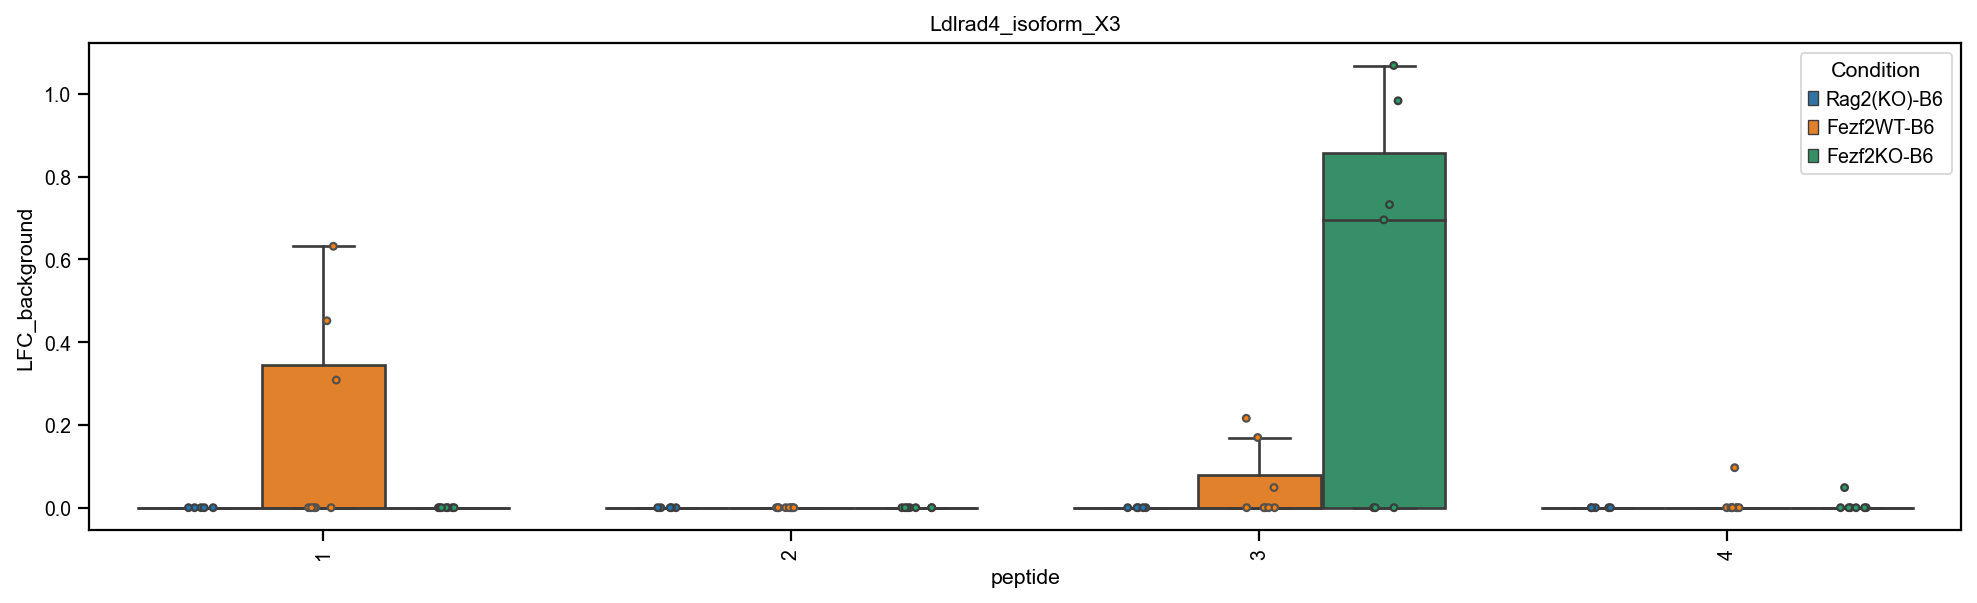

In [879]:
gene_level_box_plot(
    averaged_adata[averaged_adata.obs.Condition.isin(["Rag2(KO)-B6", "Fezf2WT-B6", "Fezf2KO-B6"])],
    "Condition",
    layer="LFC_background",
    gene="Ldlrad4",
    isoform_subset = "isoform_X3",
    figsize=(15,4),
    hue_order=["Rag2(KO)-B6", "Fezf2WT-B6", "Fezf2KO-B6"]
)

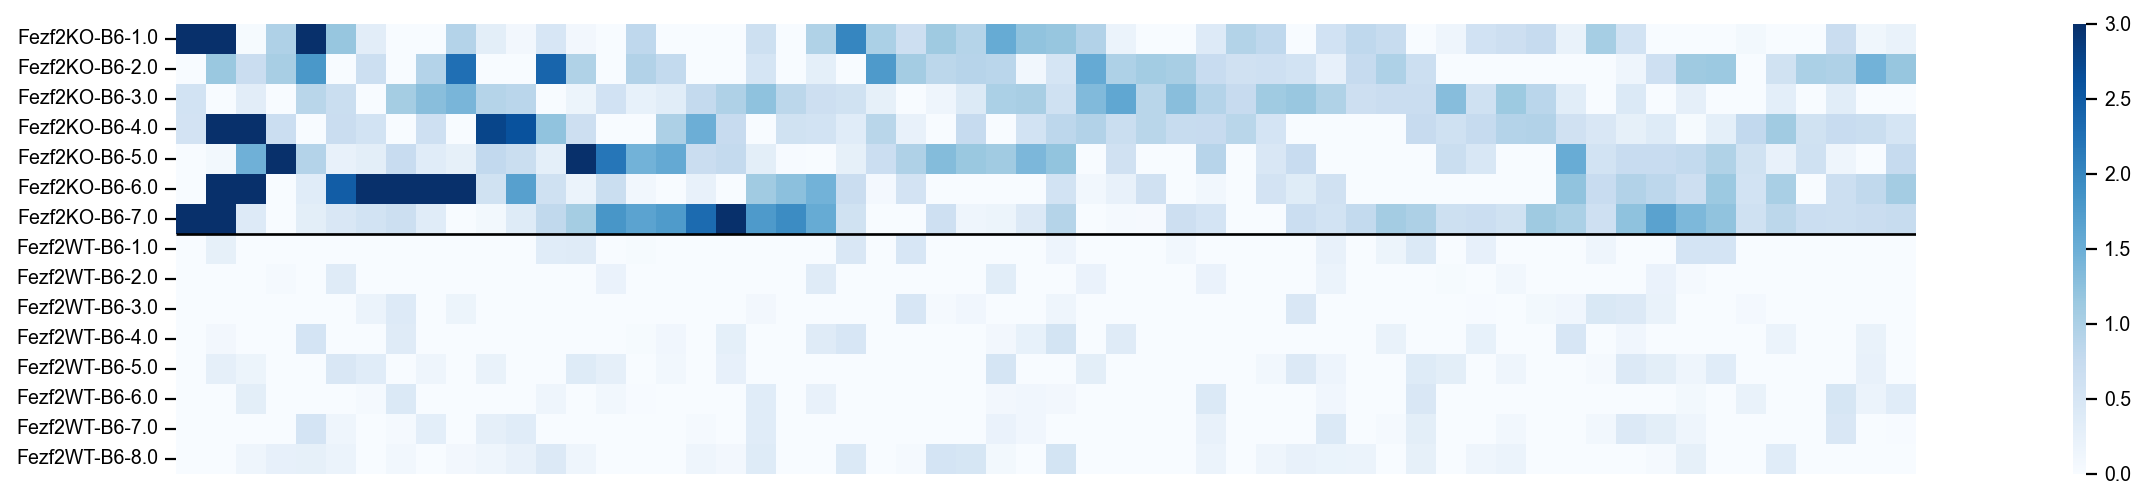

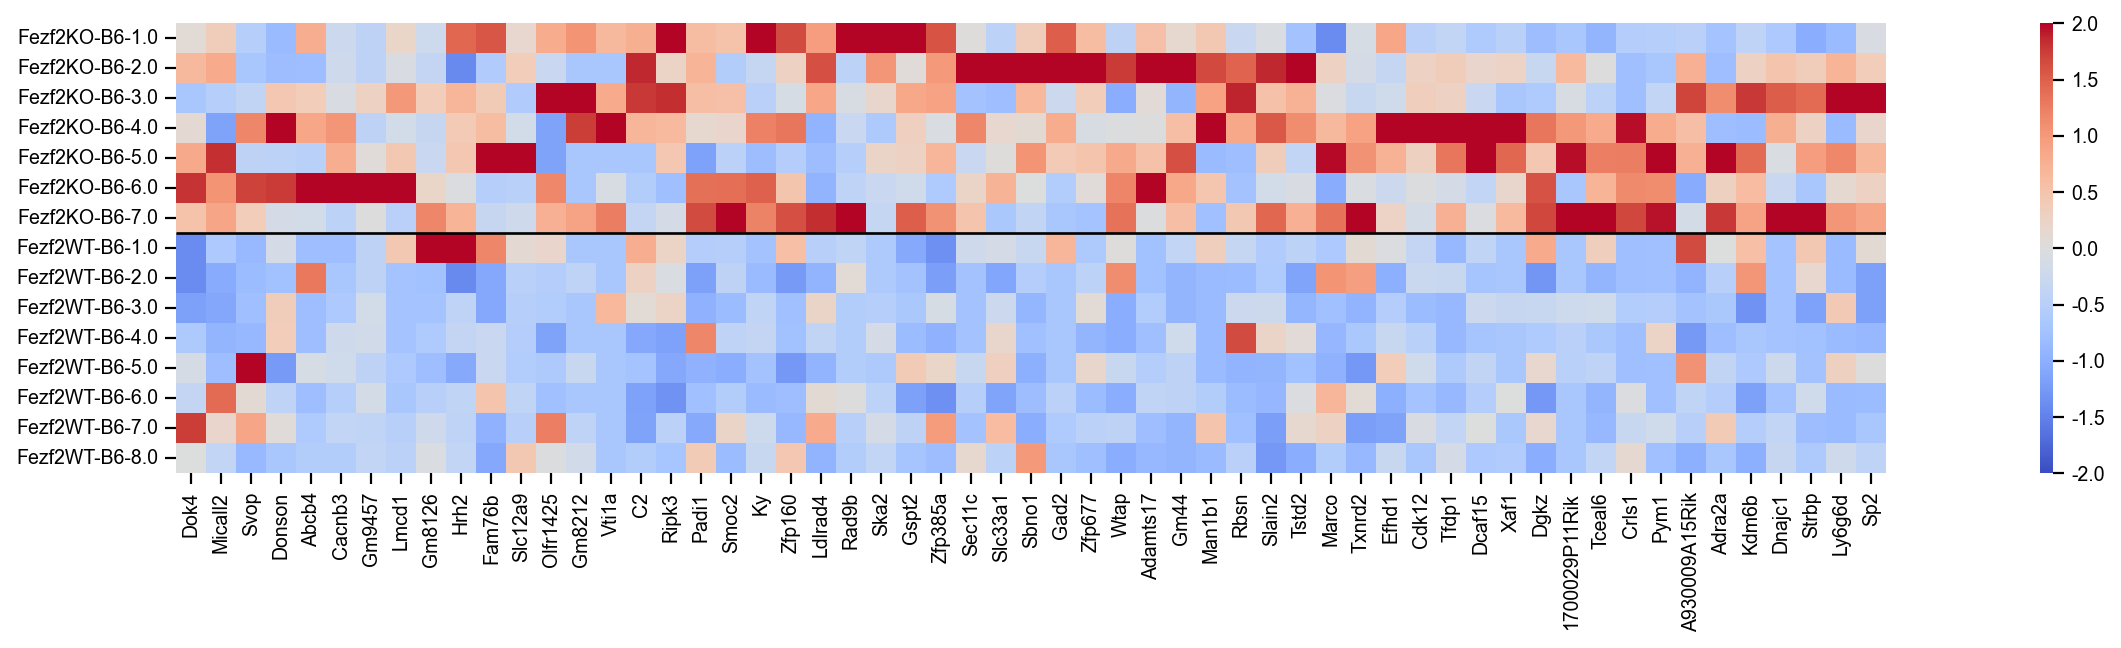

In [880]:
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in hits_Fezf2_KO_B6.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
hits_Fezf2_KO_B6["isoform"] = hits_Fezf2_KO_B6.gene + "_" + isoform

lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("B6"),
    hits_Fezf2_KO_B6.index
]
LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=3,
    cell_width=15,
    cell_height=15,
    xticklabels=False,
    grouping=[7]
)

lfc_data_peptide = rna.tl.get_expression_matrix(
    averaged_adata[:, averaged_adata.var.gene.isin(hits_Fezf2_KO_B6.gene)],
    gene_data="LFC_background"
).copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("B6"),
    :
].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in lfc_data_peptide.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
lfc_data_peptide["isoform"] = lfc_data_peptide.gene + "_" + isoform

lfc_data_peptide = lfc_data_peptide[lfc_data_peptide.isoform.isin(hits_Fezf2_KO_B6.isoform)]
del lfc_data_peptide["isoform"]

lfc_data_peptide = lfc_data_peptide.groupby("gene").sum().T

LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="coolwarm",
    vmax=2,
    vmin=-2,
    z_score=1,
    cell_width=15,
    cell_height=15,
    xticklabels=True,
    grouping=[7]
)

## Fezf2 KO CD1

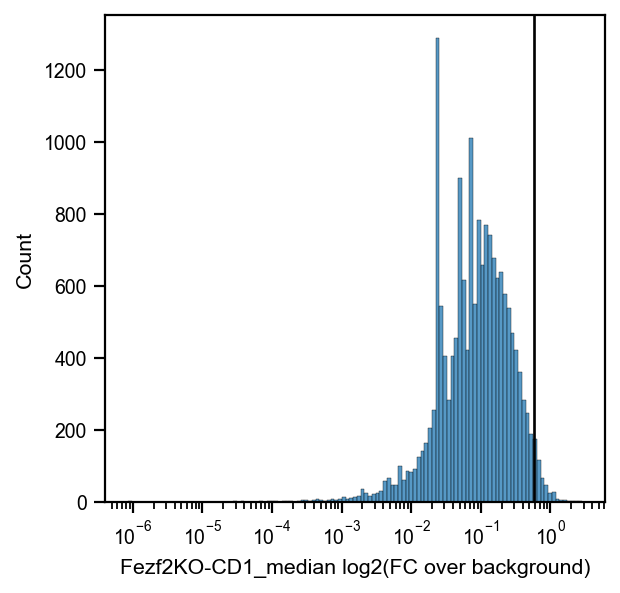

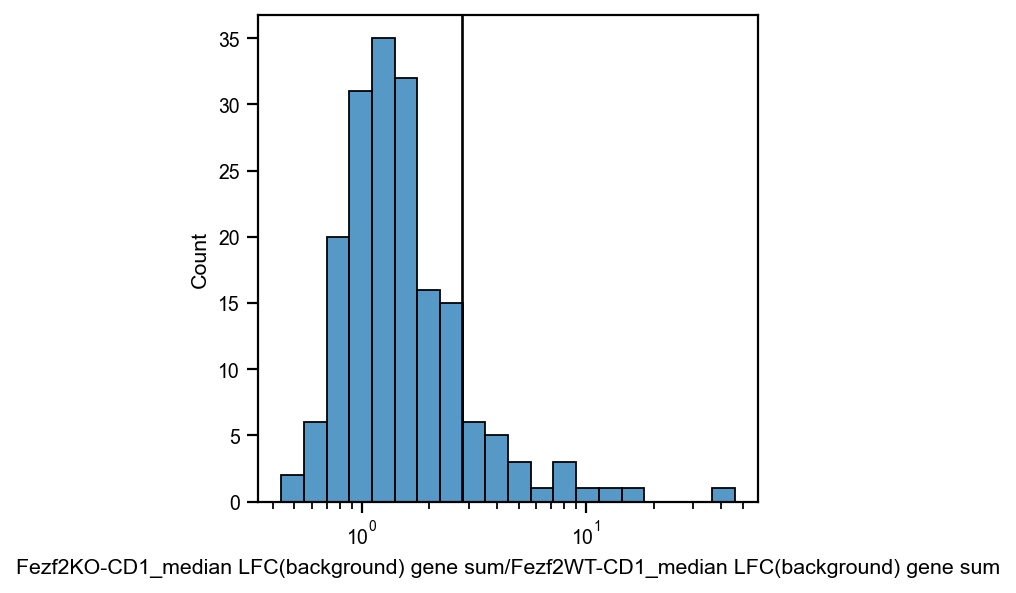

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(KO)-NOD_mean,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC
peptide,,,,,,,,,,,,,,,,,,,,,
NP_751893.3_interleukin-1_receptor-associated_kinase-like_2_isoform_a_[Mus_musculus]_seq5,0,1,0,0,1,0,2,2,0,0,...,0.275549,0.362761,0.128195,0.595315,0.294840,0.831280,1.109115,0.000000,0.179315,inf
XP_006521539.1_PREDICTED:_protein_FAM118A_isoform_X1_[Mus_musculus]_seq8,0,1,2,0,1,0,1,0,0,0,...,0.409917,0.565628,0.188877,0.377946,0.559914,0.794602,0.171141,0.037844,0.051987,inf
XP_006530181.1_PREDICTED:_2'-5'_oligoadenylate_synthetase_1C_isoform_X1_[Mus_musculus]_seq5,0,0,0,0,0,0,0,0,0,0,...,0.128127,0.188930,0.003932,0.174786,0.171139,0.593333,0.135141,0.000000,0.806100,inf
NP_001156741.1_lysophosphatidic_acid_receptor_5_[Mus_musculus]_seq8,1,0,1,0,0,0,2,0,0,0,...,0.279649,0.319984,0.011661,0.315923,0.292015,1.130648,0.365800,0.000000,0.233753,inf
NP_031944.3_eukaryotic_translation_initiation_factor_4E-binding_protein_1_[Mus_musculus]_seq2,0,1,1,0,1,0,0,0,0,0,...,0.383816,0.357931,0.015394,0.654381,0.309523,0.675230,0.223643,0.000000,1.237438,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_598664.3_spondin-2_precursor_[Mus_musculus]_seq5,0,1,0,0,1,0,0,0,0,0,...,0.349818,0.457231,0.000000,0.631225,0.546932,0.631225,0.569582,0.000000,0.466953,inf
XP_006514773.1_PREDICTED:_activator_of_90_kDa_heat_shock_protein_ATPase_homolog_2_isoform_X3_[Mus_musculus]_seq1,0,0,0,0,0,0,2,0,0,0,...,0.092229,0.032409,0.000000,0.000000,0.342768,0.858327,0.122387,0.000000,0.024746,7.436177
XP_006504285.1_PREDICTED:_cilia-_and_flagella-associated_protein_99_isoform_X5_[Mus_musculus]_seq2,1,0,0,0,1,2,2,2,0,0,...,0.398321,0.338910,0.000000,0.556814,1.411901,1.340992,1.895710,0.000000,0.250446,2.858351


In [847]:
genotype_stat = "Fezf2KO-CD1_median"
control_genotype_stat = "Fezf2WT-CD1_max"
hits_Fezf2_KO_CD1 = hits[hits[genotype_stat] > 0].copy() # Get rid of peptides with LFC over background <= 0

background_thresh = np.quantile(hits_Fezf2_KO_CD1[genotype_stat], 0.975)
sns.histplot(hits_Fezf2_KO_CD1[genotype_stat], log_scale=True)
plt.axvline(x=background_thresh, c="black")
plt.xlabel(f"{genotype_stat} log2(FC over background)")
plt.show()

hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1[genotype_stat] >= background_thresh].copy()
hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1[control_genotype_stat] < background_thresh]
hits_Fezf2_KO_CD1["gene_FC"] = list(gene_hits.loc[hits_Fezf2_KO_CD1.gene, "Fezf2KO-CD1_median"]/gene_hits.loc[hits_Fezf2_KO_CD1.gene, "Fezf2WT-CD1_median"])

hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1["gene_FC"] > 0] # Get rid of peptides with gene-wise FC over wild type = 0 

unique_genes = hits_Fezf2_KO_CD1.drop_duplicates(subset="gene")
gene_FC_thresh = np.quantile(unique_genes["gene_FC"], 0.7)
sns.histplot(unique_genes["gene_FC"], log_scale=True)
plt.axvline(x=gene_FC_thresh, c="black")
plt.xlabel("Fezf2KO-CD1_median LFC(background) gene sum/Fezf2WT-CD1_median LFC(background) gene sum")
plt.show()

hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1.gene_FC >= gene_FC_thresh]
hits_Fezf2_KO_CD1

In [848]:
hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1.sort_values(by="Fezf2KO-CD1_median")
hits_Fezf2_KO_CD1.gene

peptide
NP_852066.2_transmembrane_protein_64_[Mus_musculus]_seq1                                       Tmem64
XP_006505827.1_PREDICTED:_DNA_repair_protein_RAD52_homolog_isoform_X1_[Mus_musculus]_seq5       Rad52
NP_694733.3_SUMO-1_specific_protease_4_[Mus_musculus]_seq6                                   AF366264
XP_006521539.1_PREDICTED:_protein_FAM118A_isoform_X1_[Mus_musculus]_seq8                      Fam118a
NP_796275.3_heterogeneous_nuclear_ribonucleoprotein_L_[Mus_musculus]_seq8                      Hnrnpl
                                                                                               ...   
NP_001156741.1_lysophosphatidic_acid_receptor_5_[Mus_musculus]_seq8                             Lpar5
XP_006540741.1_PREDICTED:_aminopeptidase_N_isoform_X1_[Mus_musculus]_seq5                       Anpep
NP_058051.3_sulfotransferase_1_family_member_D1_[Mus_musculus]_seq6                           Sult1d1
XP_006515672.1_PREDICTED:_endoribonuclease_Dicer_isoform_X1_[Mus_musculus]

In [849]:
hits_Fezf2_KO_CD1.sort_values(by="gene_FC").gene

peptide
XP_006508336.1_PREDICTED:_ubiquitin_carboxyl-terminal_hydrolase_47_isoform_X1_[Mus_musculus]_seq10       Usp47
XP_006504285.1_PREDICTED:_cilia-_and_flagella-associated_protein_99_isoform_X5_[Mus_musculus]_seq2      Cfap99
NP_848825.2_serine/threonine-protein_kinase_SIK2_[Mus_musculus]_seq21                                     Sik2
XP_017174749.1_PREDICTED:_formin-like_protein_2_isoform_X3_[Mus_musculus]_seq11                          Fmnl2
XP_006515672.1_PREDICTED:_endoribonuclease_Dicer_isoform_X1_[Mus_musculus]_seq15                        Dicer1
                                                                                                        ...   
NP_001104749.1_WD_repeat_and_FYVE_domain-containing_protein_1_isoform_1_[Mus_musculus]_seq6              Wdfy1
NP_598579.1_ashwin_[Mus_musculus]_seq4                                                                AI597479
NP_033550.2_protein_Wnt-5a_isoform_1_precursor_[Mus_musculus]_seq7                                      

In [909]:
hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1.gene == "Ak5"]

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC,isoform
peptide,,,,,,,,,,,,,,,,,,,,,
XP_006501503.1_PREDICTED:_adenylate_kinase_isoenzyme_5_isoform_X2_[Mus_musculus]_seq10,0,0,1,0,1,0,0,0,0,0,...,0.244741,0.0,0.322216,0.23882,0.517409,0.48698,0.0,0.189984,inf,Ak5_isoform_X2


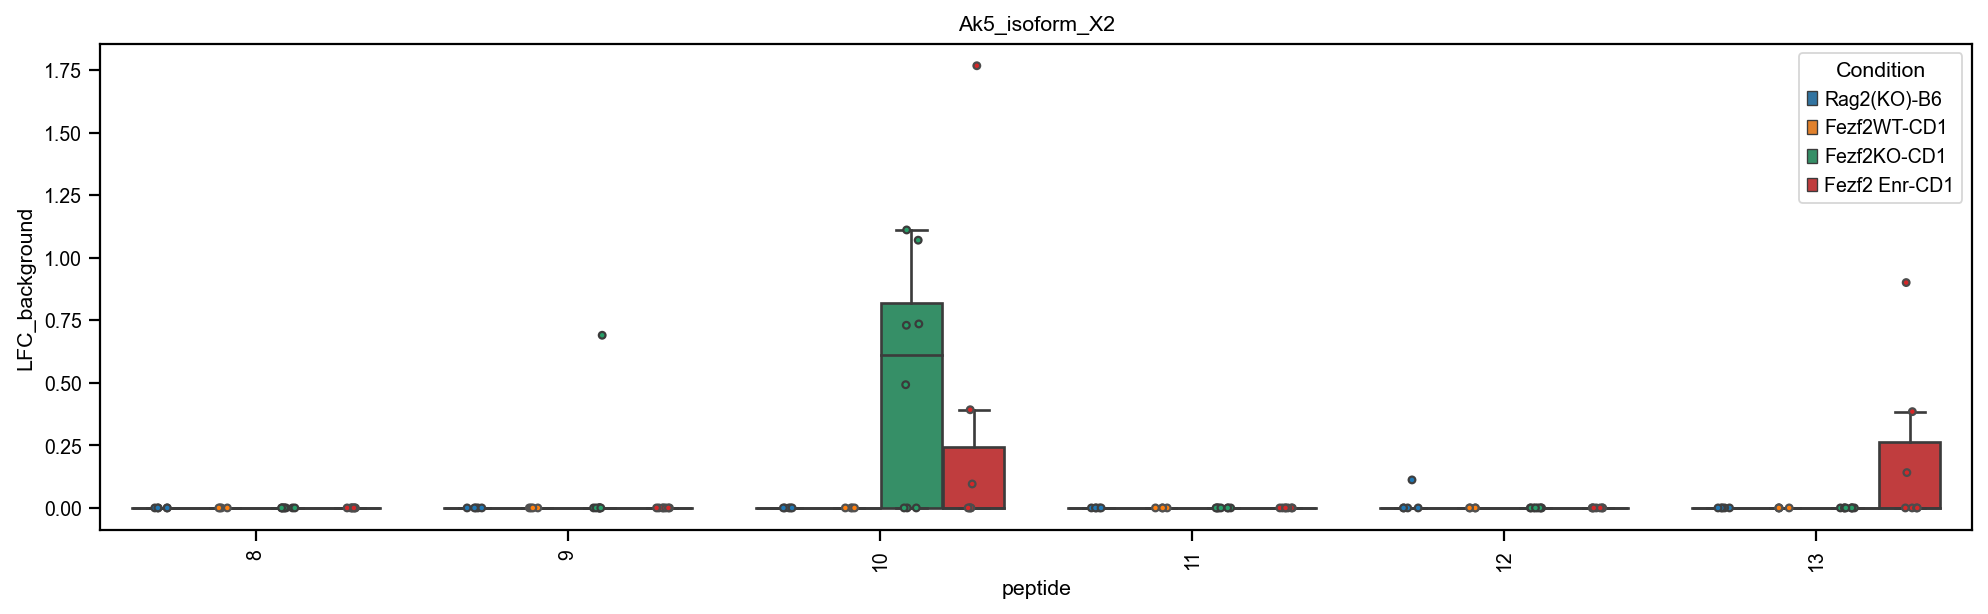

In [910]:
gene_level_box_plot(
    averaged_adata,
    "Condition",
    layer="LFC_background",
    gene="Ak5",
    isoform_subset = "isoform_X2",
    figsize=(15,4),
    hue_order=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"]
)

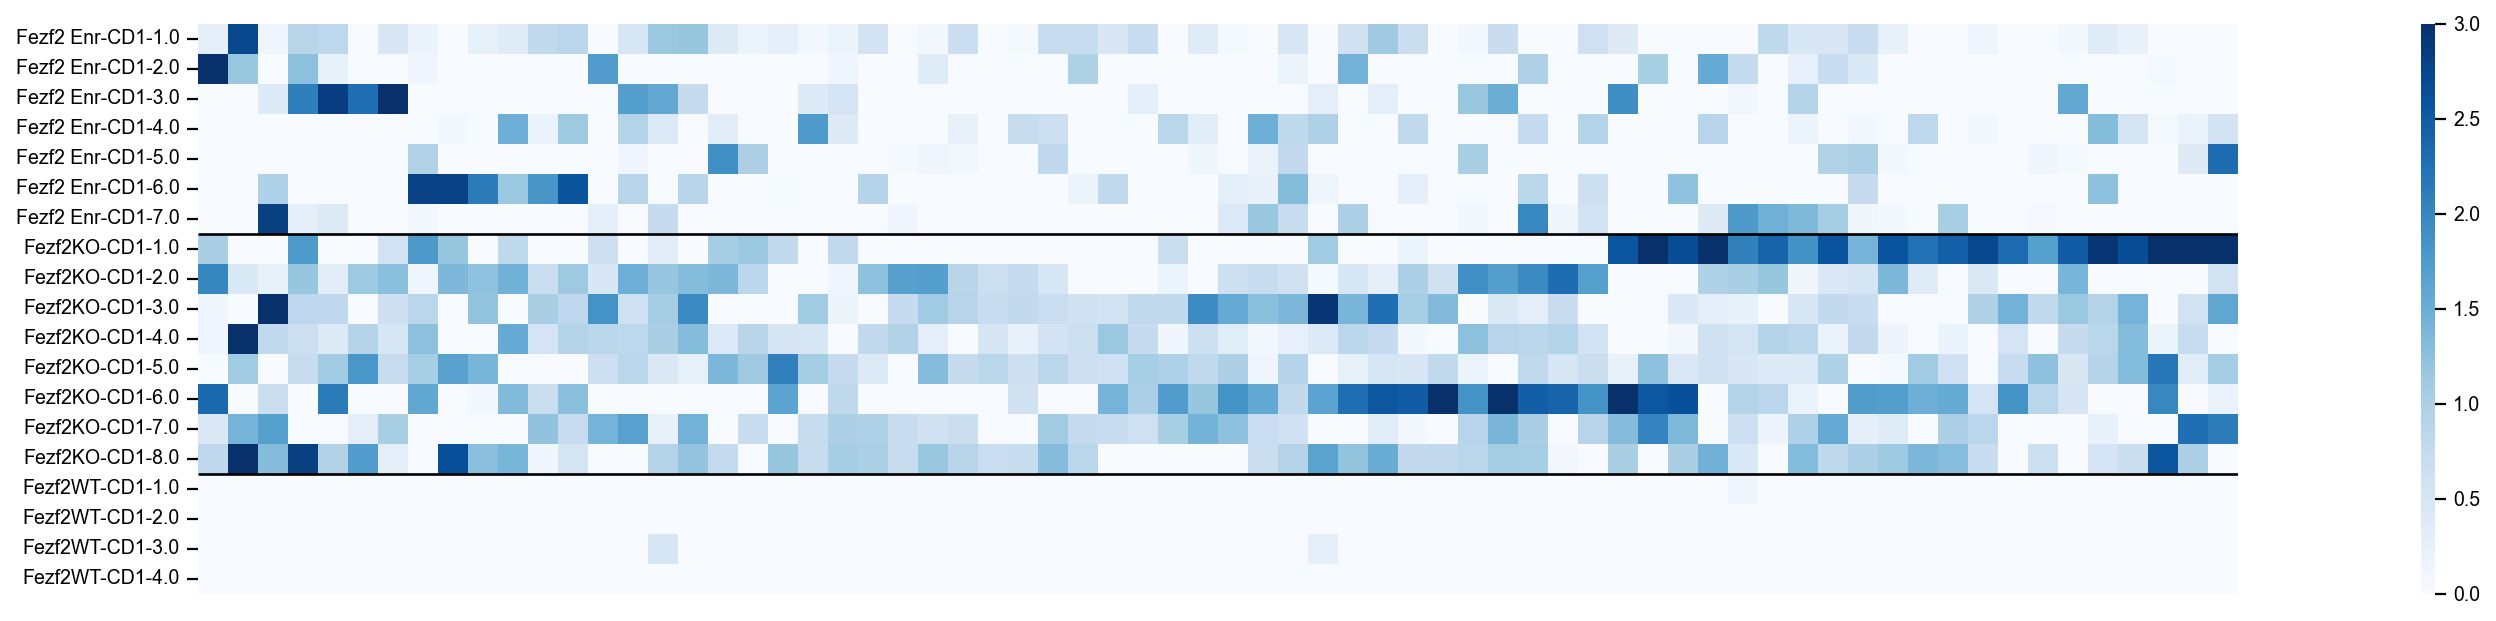

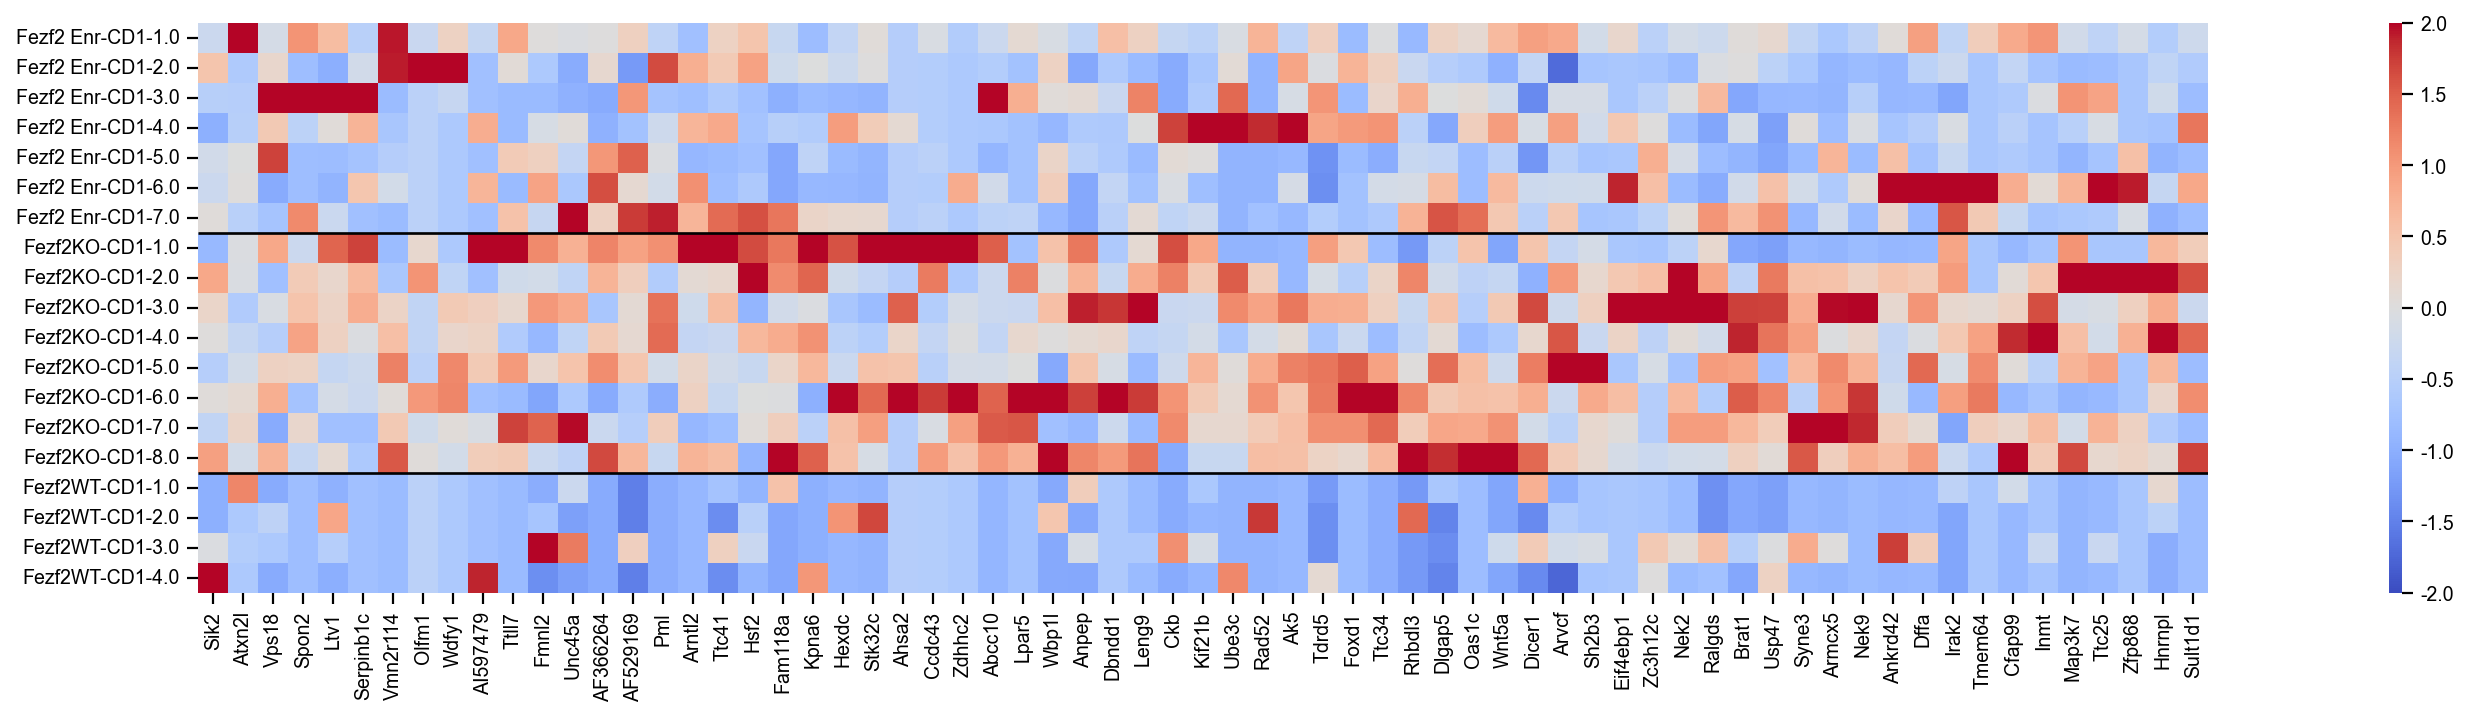

In [851]:
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in hits_Fezf2_KO_CD1.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
hits_Fezf2_KO_CD1["isoform"] = hits_Fezf2_KO_CD1.gene + "_" + isoform

lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("CD1"),
    hits_Fezf2_KO_CD1.index
]
LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=3,
    cell_width=15,
    cell_height=15,
    xticklabels=False,
    grouping=[7,15]
)

lfc_data_peptide = rna.tl.get_expression_matrix(
    averaged_adata[:, averaged_adata.var.gene.isin(hits_Fezf2_KO_CD1.gene)],
    gene_data="LFC_background"
).copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("CD1"),
    :
].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in lfc_data_peptide.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
lfc_data_peptide["isoform"] = lfc_data_peptide.gene + "_" + isoform

lfc_data_peptide = lfc_data_peptide[lfc_data_peptide.isoform.isin(hits_Fezf2_KO_CD1.isoform)]
del lfc_data_peptide["isoform"]

lfc_data_peptide = lfc_data_peptide.groupby("gene").sum().T

LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="coolwarm",
    vmax=2,
    vmin=-2,
    z_score=1,
    cell_width=15,
    cell_height=15,
    xticklabels=True,
    grouping=[7,15]
)

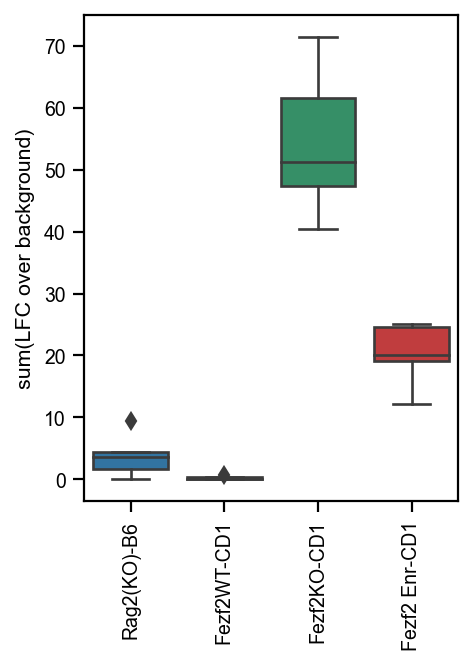

In [852]:
plot_FC_sum(
    averaged_adata[:,averaged_adata.var.index.isin(hits_Fezf2_KO_CD1.index)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    order=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    save_path=None
)

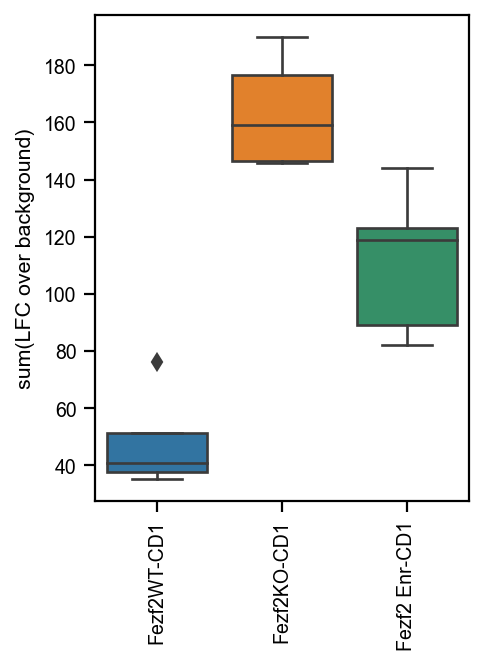

In [853]:
plot_FC_sum(
    averaged_adata[:,averaged_adata.var.gene.isin(hits_Fezf2_KO_CD1.gene)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    order=["Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    save_path=None
)

## Fezf2 EnR CD1

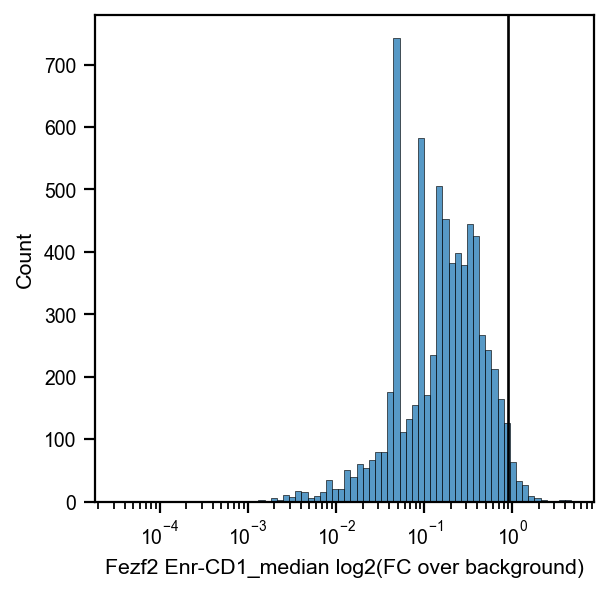

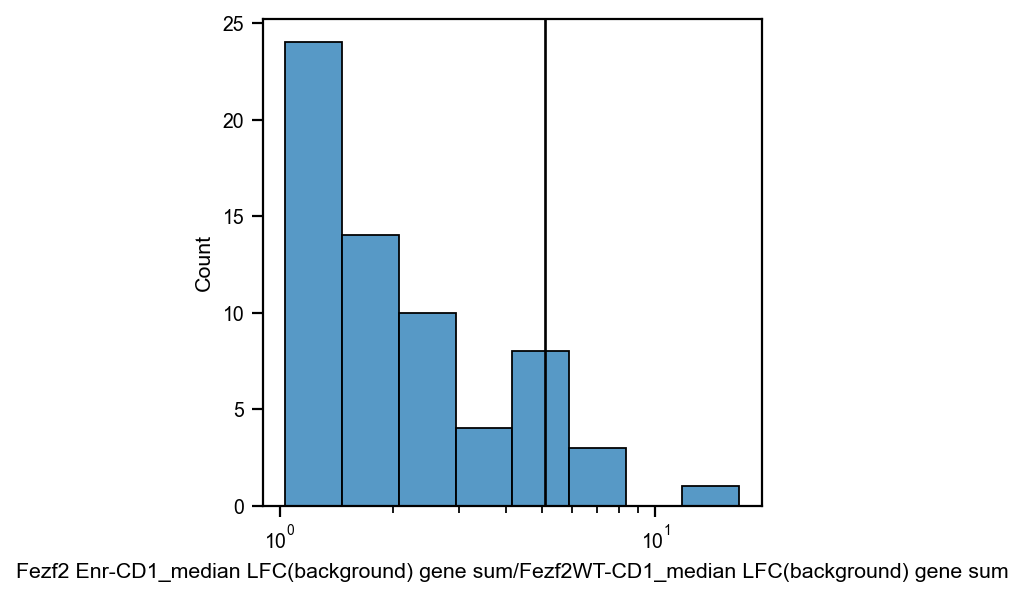

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(KO)-NOD_mean,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC
peptide,,,,,,,,,,,,,,,,,,,,,
NP_114387.1_centrosomal_protein_of_41_kDa_[Mus_musculus]_seq6,0,1,0,0,2,0,1,0,0,0,...,0.380638,0.342613,0.039615,0.991798,0.761803,0.346879,0.244424,0.000000,0.109168,inf
XP_011238090.1_PREDICTED:_zinc_finger_protein_2_isoform_X2_[Mus_musculus]_seq7,0,0,1,0,1,0,0,0,0,0,...,0.375960,0.324172,0.075617,1.468067,0.302608,0.194906,0.492942,0.000000,0.421802,inf
NP_001272418.1_nucleosome_assembly_protein_1-like_4_isoform_a_[Mus_musculus]_seq8,1,0,0,0,2,0,0,0,0,0,...,0.329444,0.334804,0.073289,0.946525,0.294725,0.213365,0.235227,0.000000,0.374758,inf
XP_006510337.1_PREDICTED:_zinc_finger_protein_317_isoform_X1_[Mus_musculus]_seq3,0,0,0,0,0,0,1,0,0,0,...,0.301404,0.545773,0.057643,0.896314,0.706286,0.524886,0.352797,0.000000,0.401374,inf
XP_011247797.1_PREDICTED:_ADP-ribosylation_factor-like_protein_9_isoform_X3_[Mus_musculus]_seq2,0,1,0,0,0,1,0,0,0,0,...,0.649948,0.483201,0.000000,0.645036,0.702348,0.190083,0.357777,0.000000,0.622739,inf
XP_006528757.1_PREDICTED:_rho_GTPase-activating_protein_6_isoform_X1_[Mus_musculus]_seq22,0,4,3,0,1,0,1,1,0,0,...,0.757110,0.740805,0.051738,0.996709,0.293981,0.459309,0.651083,0.000000,1.059331,5.193685
XP_017177353.1_PREDICTED:_uncharacterized_protein_LOC108169152_isoform_X1_[Mus_musculus]_seq5,1,1,0,0,4,2,0,1,0,0,...,0.219927,0.064589,0.149839,1.845421,2.228790,0.383326,0.840906,0.142191,0.350519,6.539493
XP_006540423.1_PREDICTED:_carcinoembryonic_antigen-related_cell_adhesion_molecule_20_isoform_X1_[Mus_musculus]_seq4,0,0,0,0,0,0,0,0,0,0,...,0.186135,0.063894,0.000000,0.636403,0.056339,0.000000,0.096582,0.000000,0.118348,inf
XP_006532992.1_PREDICTED:_WSC_domain-containing_protein_1_isoform_X1_[Mus_musculus]_seq8,0,1,0,0,2,1,0,1,0,0,...,0.287681,0.304887,0.116687,1.113980,0.568424,0.167272,0.858582,0.000000,0.000000,inf


In [856]:
genotype_stat = "Fezf2 Enr-CD1_median"
control_genotype_stat = "Fezf2WT-CD1_max"
hits_Fezf2_EnR_CD1 = hits[hits[genotype_stat] > 0].copy() # Get rid of peptides with LFC over background <= 0

background_thresh = np.quantile(hits_Fezf2_EnR_CD1[genotype_stat], 0.975)
sns.histplot(hits_Fezf2_EnR_CD1[genotype_stat], log_scale=True)
plt.axvline(x=background_thresh, c="black")
plt.xlabel(f"{genotype_stat} log2(FC over background)")
plt.show()

hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1[hits_Fezf2_EnR_CD1[genotype_stat] >= background_thresh].copy()
hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1[hits_Fezf2_EnR_CD1[control_genotype_stat] < background_thresh]
hits_Fezf2_EnR_CD1["gene_FC"] = list(gene_hits.loc[hits_Fezf2_EnR_CD1.gene, "Fezf2 Enr-CD1_median"]/gene_hits.loc[hits_Fezf2_EnR_CD1.gene, "Fezf2WT-CD1_median"])

hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1[hits_Fezf2_EnR_CD1["gene_FC"] > 1] # Get rid of peptides with gene-wise FC over wild type <= 1

unique_genes = hits_Fezf2_EnR_CD1.drop_duplicates(subset="gene")
gene_FC_thresh = np.quantile(unique_genes["gene_FC"], 0.7)
sns.histplot(unique_genes["gene_FC"], log_scale=True)
plt.axvline(x=gene_FC_thresh, c="black")
plt.xlabel("Fezf2 Enr-CD1_median LFC(background) gene sum/Fezf2WT-CD1_median LFC(background) gene sum")
plt.show()

hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1[hits_Fezf2_EnR_CD1.gene_FC >= gene_FC_thresh]
hits_Fezf2_EnR_CD1

In [857]:
hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1.sort_values(by="Fezf2 Enr-CD1_median", ascending=False)
hits_Fezf2_EnR_CD1.gene

peptide
NP_084484.2_probable_tRNA_(uracil-O(2)-)-methyltransferase_[Mus_musculus]_seq2                                                Trmt44
XP_017177353.1_PREDICTED:_uncharacterized_protein_LOC108169152_isoform_X1_[Mus_musculus]_seq5                                Gm46965
NP_062740.1_prostaglandin_E_synthase_3_[Mus_musculus]_seq3                                                                    Ptges3
NP_001094980.1_sushi_domain-containing_protein_5_precursor_[Mus_musculus]_seq5                                                 Susd5
XP_006528757.1_PREDICTED:_rho_GTPase-activating_protein_6_isoform_X1_[Mus_musculus]_seq22                                    Arhgap6
XP_017168538.1_PREDICTED:_cell_surface_glycoprotein_1_[Mus_musculus]_seq8                                              9530057J20Rik
NP_080397.1_BAG_family_molecular_chaperone_regulator_4_[Mus_musculus]_seq5                                                      Bag4
NP_001272418.1_nucleosome_assembly_protein_1-like_4_isoform_a

In [858]:
hits_Fezf2_EnR_CD1.gene_FC

peptide
NP_084484.2_probable_tRNA_(uracil-O(2)-)-methyltransferase_[Mus_musculus]_seq2                                               inf
XP_017177353.1_PREDICTED:_uncharacterized_protein_LOC108169152_isoform_X1_[Mus_musculus]_seq5                           6.539493
NP_062740.1_prostaglandin_E_synthase_3_[Mus_musculus]_seq3                                                                   inf
NP_001094980.1_sushi_domain-containing_protein_5_precursor_[Mus_musculus]_seq5                                          8.001450
XP_006528757.1_PREDICTED:_rho_GTPase-activating_protein_6_isoform_X1_[Mus_musculus]_seq22                               5.193685
XP_017168538.1_PREDICTED:_cell_surface_glycoprotein_1_[Mus_musculus]_seq8                                                    inf
NP_080397.1_BAG_family_molecular_chaperone_regulator_4_[Mus_musculus]_seq5                                              6.273441
NP_001272418.1_nucleosome_assembly_protein_1-like_4_isoform_a_[Mus_musculus]_seq8        

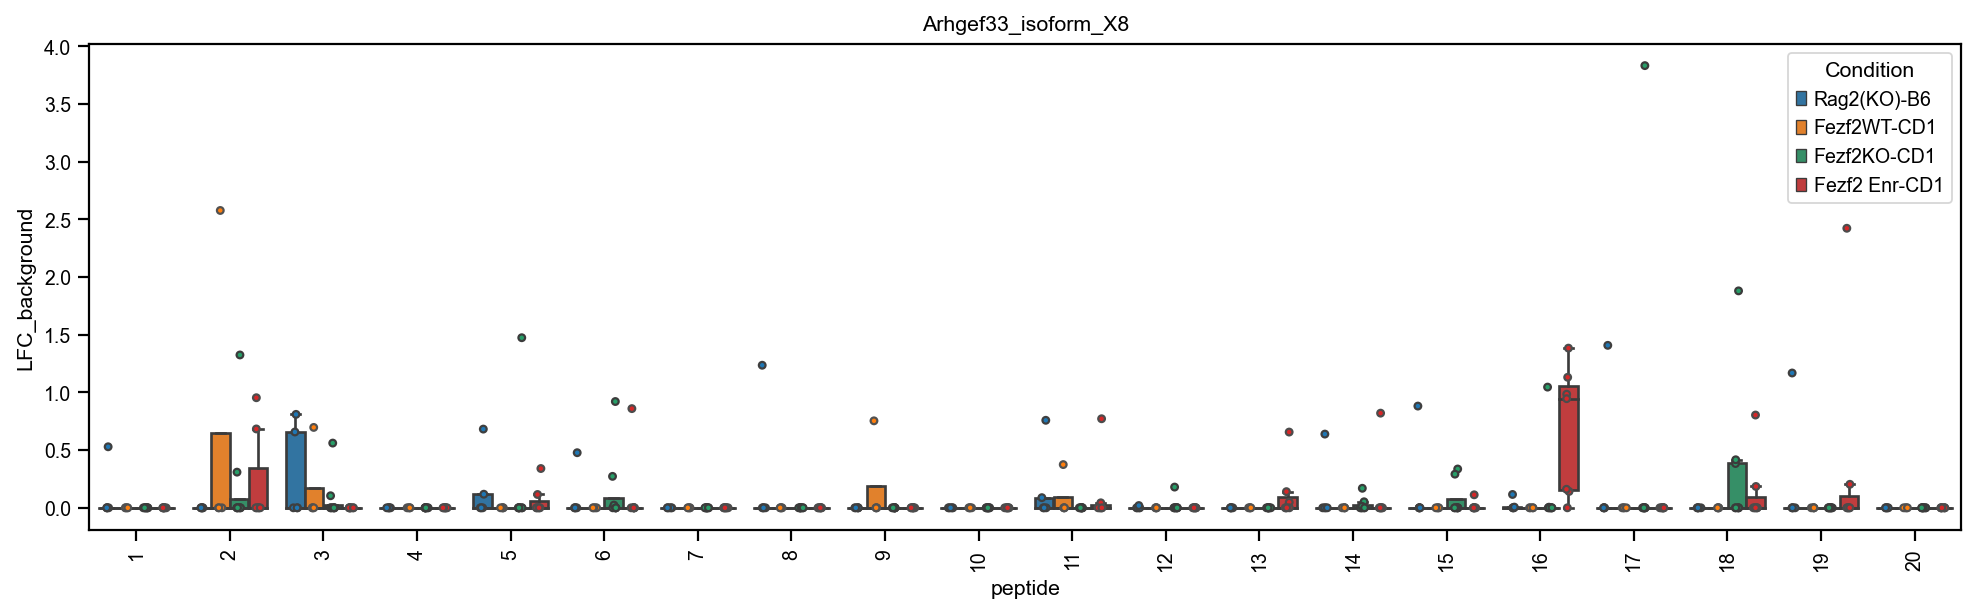

In [859]:
gene_level_box_plot(
    averaged_adata,
    "Condition",
    layer="LFC_background",
    gene="Arhgef33",
    isoform_subset = "isoform_X8",
    figsize=(15,4),
    hue_order=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"]
)

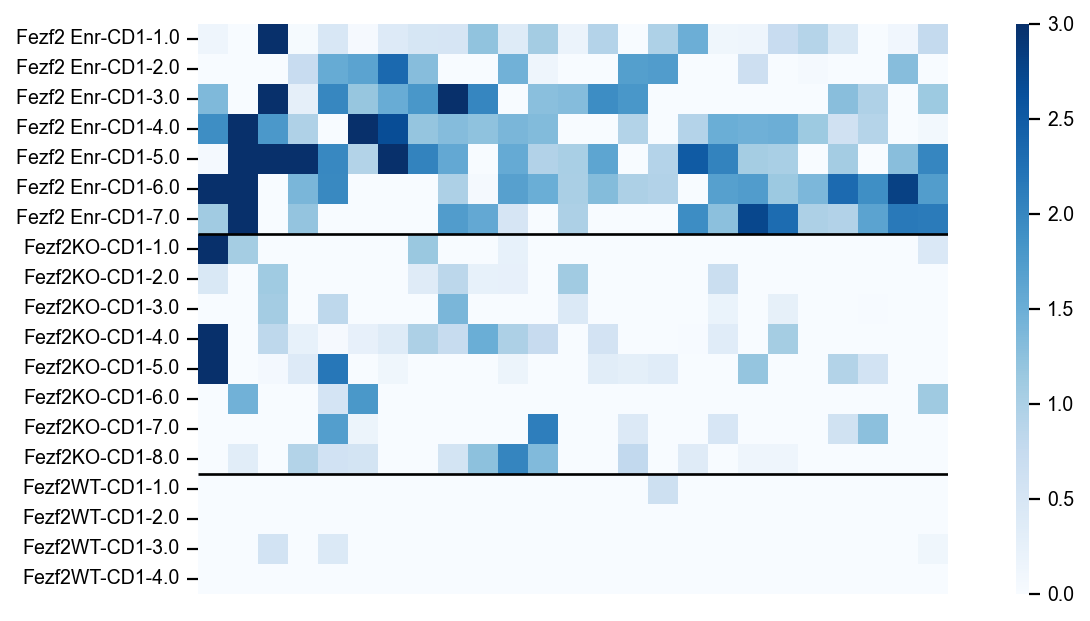

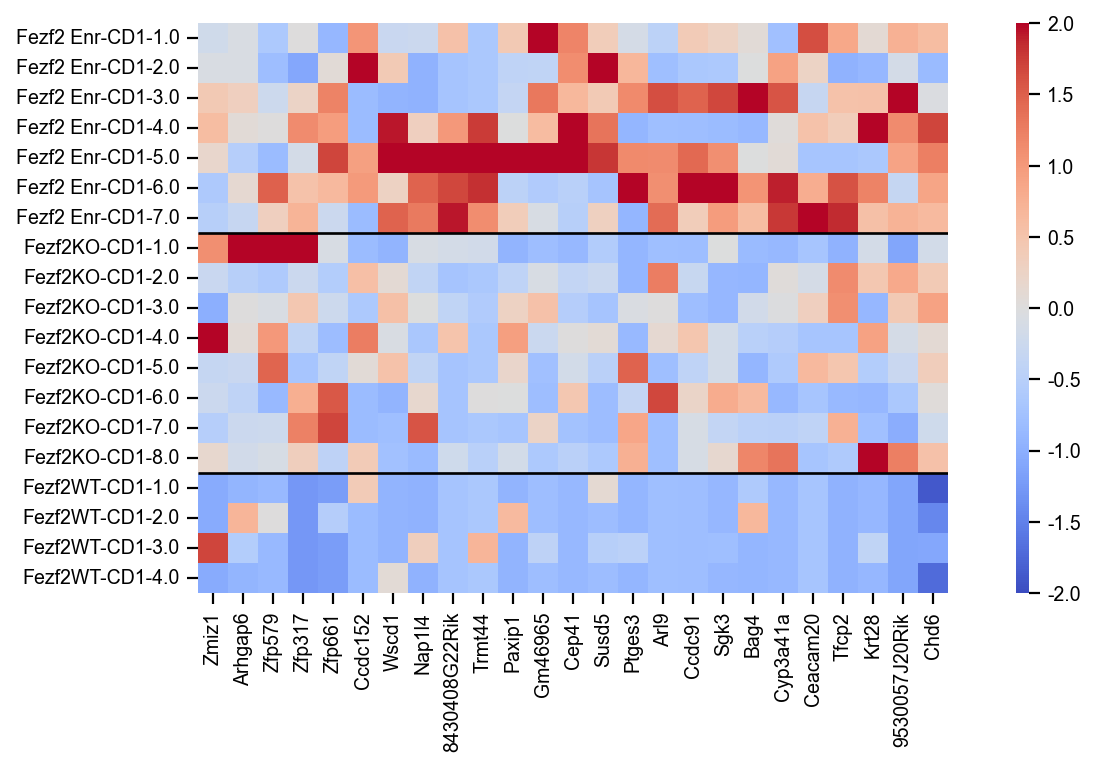

In [860]:
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in hits_Fezf2_EnR_CD1.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
hits_Fezf2_EnR_CD1["isoform"] = hits_Fezf2_EnR_CD1.gene + "_" + isoform

lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("CD1"),
    hits_Fezf2_EnR_CD1.index
]
LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=3,
    cell_width=15,
    cell_height=15,
    xticklabels=False,
    grouping=[7,15]
)

lfc_data_peptide = rna.tl.get_expression_matrix(
    averaged_adata[:, averaged_adata.var.gene.isin(hits_Fezf2_EnR_CD1.gene)],
    gene_data="LFC_background"
).copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("CD1"),
    :
].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in lfc_data_peptide.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
lfc_data_peptide["isoform"] = lfc_data_peptide.gene + "_" + isoform

lfc_data_peptide = lfc_data_peptide[lfc_data_peptide.isoform.isin(hits_Fezf2_EnR_CD1.isoform)]
del lfc_data_peptide["isoform"]

lfc_data_peptide = lfc_data_peptide.groupby("gene").sum().T

LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="coolwarm",
    vmax=2,
    vmin=-2,
    z_score=1,
    cell_width=15,
    cell_height=15,
    xticklabels=True,
    grouping=[7,15]
)

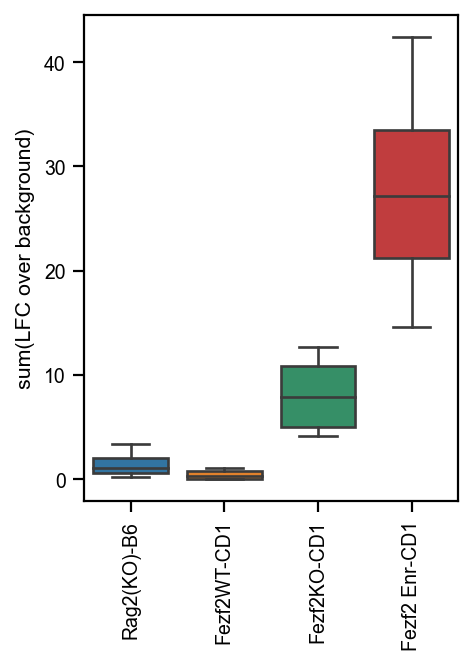

In [861]:
plot_FC_sum(
    averaged_adata[:,averaged_adata.var.index.isin(hits_Fezf2_EnR_CD1.index)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    order=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    save_path=None
)

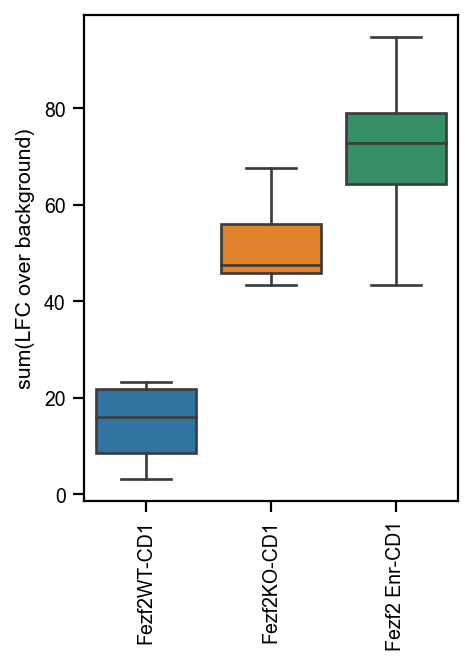

In [862]:
plot_FC_sum(
    averaged_adata[:,averaged_adata.var.gene.isin(hits_Fezf2_EnR_CD1.gene)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    order=["Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    save_path=None
)